# 1 Regression Methods

## 1.1 Processing Stock Price Data in Python

### 1.1.1 Natural-Log Transform

In [1]:
# Import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import VAR
import copy

# Set data folder path
files_path = 'DataSource/'

In [2]:
# Read data
px = pd.read_csv(files_path+'priceData.csv', header=0, index_col=0)
px = px.dropna() # delete the NaN entries

logpx = np.log(px)

The figure below shows the price of the SPX index since 1930 and the natural-log transform of the price. The natural-log transform compresses the range of the price data, which makes it easier to process. 

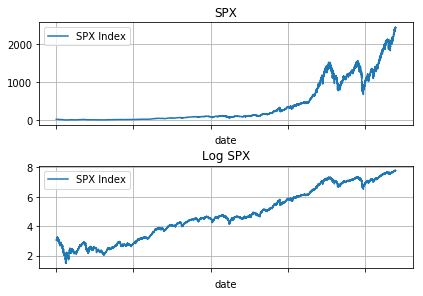

In [3]:
fig, axes = plt.subplots(2,1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

px.plot(ax=axes[0], grid=True, title='SPX')
logpx.plot(ax=axes[1], grid=True, title='Log SPX')

### 1.1.2 Stationarity

A stochastic signal is considered wide-sense stationary (WSS) if the first moment (the mean) is time invariant and the autocorrelation function is dependent on time differences only. 

\begin{equation}
m_x(t) = m_x(t+T), \text{for any } T
\end{equation}

\begin{equation}
R_{xx}(t_1,t_2) = R_{xx}(t_1-t_2), \text{for any } t_1, t_2
\end{equation}

Stationarity is an important characteristic to explore in financial markets, since such characteristics would imply that the signal's average persists over time and that the autocorrelaion is dependent on time differences only. This would justify investing strategies based on mean-reverting behaviour of the signal. 

The figures below shows the sliding mean and standard deviation of the prices series (left column) and log-prices series (right column), which demonstrates the stationarity characteristics of the given time series.  Overall, the sliding mean (or the moving average) smoothens the signal, while the sliding standard deviation represents its volatility over the past year (252 trading days). 

As shown in the figure, the moving average increases over time for both the price and the log-price, which implies non-stationarity. However, the sliding standard deviation shows more consistent behaviour, oscillating about 0.068. Overall, the price signal is not stationary.

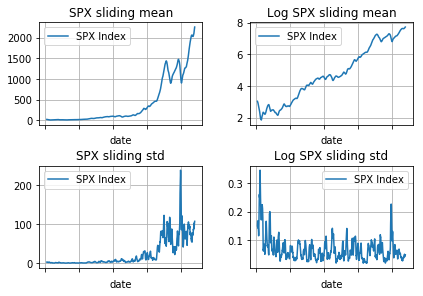

In [4]:
# Sliding window analysis
window = 252 # 252 trading days in a market

fig, axes = plt.subplots(2,2)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

# Plot sliding window statistics for prices
px.rolling(window).mean().plot(ax=axes[0,0], grid=True, title='SPX sliding mean')
px.rolling(window).std().plot(ax=axes[1,0], grid=True, title='SPX sliding std')

# Plot sliding window statistics for log prices
logpx.rolling(window).mean().plot(ax=axes[0,1], grid=True, title='Log SPX sliding mean')
logpx.rolling(window).std().plot(ax=axes[1,1], grid=True, title='Log SPX sliding std')

#print(logpx.rolling(window).std().mean())

### 1.1.3 Returns

In stead of looking at the price data, it is often more useful to look at the return characteristics of the signal in terms of stationarity. In this case, the simple return is defined as the percentage increase at each time step

\begin{equation}
r_{simple} = \frac{p_t - p_{t-1}}{p_{t-1}}
\end{equation}

while the log return is defined as the difference between successive log values

\begin{equation}
r_{log} = ln \frac{p_t}{p_{t-1}} = {ln(p_t)}-{ln(p_{t-1})}
\end{equation}

The figure below shows the sliding window analysis applied to the return signals. By looking at the returns, the signal is much more well-behaved, with the moving average for both returns oscillating about 0, hence showing more stationarity. 

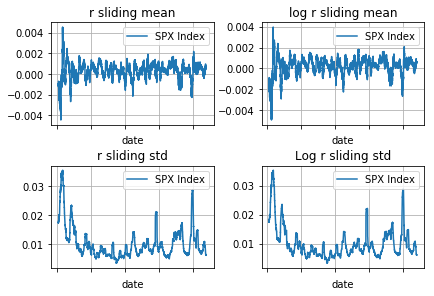

In [5]:
# Generate log returns 
simpret = px.pct_change() # simple return
logret = logpx.diff() # log return

fig, axes = plt.subplots(2,2)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

# Plot sliding window statistics for prices
simpret.rolling(window).mean().plot(ax=axes[0,0], grid=True, title='r sliding mean')
simpret.rolling(window).std().plot(ax=axes[1,0], grid=True, title='r sliding std')

# Plot sliding window statistics for log prices
logret.rolling(window).mean().plot(ax=axes[0,1], grid=True, title='log r sliding mean')
logret.rolling(window).std().plot(ax=axes[1,1], grid=True, title='Log r sliding std')


### 1.1.4 Advantages of log-returns

In quantitative finance, prices are often assumed to be log-normally distributed in the short-run (in the long-run it is more skewed due to the market being generally upward trending), which means that the log return $log(\frac{p_{t+1}}{p_t}) = log(1+r_{simple})$ is normally distributed. This can be shown visually with the histograms below, which plots the distribution of daily returns. This additional advantage of Gaussianity is essential for signal processing, since most signal processing models and other statistical techniques assume Gaussianity (e.g. Z-score). In addition, by looking at returns, it creates a metric that makes assets comparable with each other, which is essential for multi-dimensional analysis.

Text(0.5,1,'Simple r')

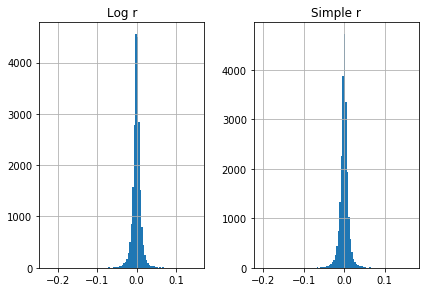

In [6]:
fig, axes = plt.subplots(1,2)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

logret.hist(ax=axes[0], bins=100)
axes[0].set_title('Log r')
simpret.hist(ax=axes[1], bins=100)
axes[1].set_title('Simple r')

To formally test Gaussianity, it is possible to use the "Jarque-Bera" test which checks to what extent the sample data's skewness (how symmetric is the sample data) and kurtosis (how fat is the tail of the distribution) matches a normal distribution, which has skewness 0 and kurtosis 3. The statistic is defined as:

\begin{equation}
JB = \frac{n}{6} (S^2 + \frac{(C-3)^2}{4})
\end{equation}

where n is the number of observations, S is the sample skewness and C is the sample kurtosis. Therefore, the closer the data sample follows a normal distribution with S=0 and C=3, the closer to 0 is the JB statistic. 

The figure below shows the difference between the JB test statistic for simple returns and log returns. It is clear from the graph that as number of data points increases, the greater is the difference between the JB value for simple returns and log returns, meaning that simple returns deviates further away from the normal distribution. This proves that the log-returns shows more Gaussianity than simple returns. In addition, the p-value for the JB statistic is around 0 for both cases for number of data points greater than 300, which shows that we are can be confident about the above conclusion.

Finally, the JB test statistic shows that for both the simple return and log return cases, the data demonstrates more normality for less data points. This is also expected since the upward trend of the market skews the return distribution in the long run.

In [7]:
log_JB = [stats.jarque_bera(logret.dropna()[:i])[0] for i in range (100, len(logret.dropna()), 100)]
simp_JB = [stats.jarque_bera(simpret.dropna()[:i])[0] for i in range (100, len(simpret.dropna()), 100)]
log_JBp = [stats.jarque_bera(logret.dropna()[:i])[1] for i in range (100, len(logret.dropna()), 100)]
simp_JBp = [stats.jarque_bera(simpret.dropna()[:i])[1] for i in range (100, len(simpret.dropna()), 100)]
x = [i for i in range (100, len(simpret.dropna()), 100)]

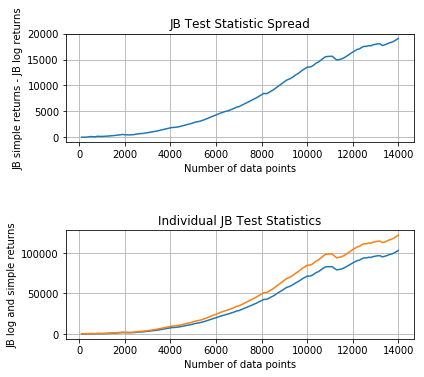

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(x[:140], (np.array(simp_JB[:140])-np.array(log_JB[:140])))
ax1.grid()
ax1.set_ylabel('JB simple returns - JB log returns')
ax1.set_xlabel('Number of data points')
ax1.set_title('JB Test Statistic Spread')

ax2.plot(x[:140], (np.array(log_JB[:140])))
ax2.plot(x[:140], (np.array(simp_JB[:140])))
ax2.grid()
ax2.set_ylabel('JB log and simple returns')
ax2.set_xlabel('Number of data points')
ax2.set_title('Individual JB Test Statistics')

fig.tight_layout()
fig.set_size_inches(6,6)

# plt.plot(x[:140], log_JBp[:140])
# plt.plot(x[:140], simp_JBp[:140])

For signal processing purposes, log-returns are often preferred for several reasons other than its normality. For instance, it is  time additive for calculating compounded returns (explored in the next section) which is computationally and numerically stable. In addition, it's better suited for mathematical analysis since $\frac{p_{t+1}}{p_t} = e^{log(\frac{p_{t+1}}{p_t})}$, and exponents are easier to manipulate with integration and differentiation in stochastic calculus. Finally, for small values of $r_{simple}$, the log return $log(\frac{p_{t+1}}{p_t})=log(1+r_{simple})\approx r_{simple}$, which is a valid assumption for the short term. 

In [9]:
print('Log return JB, p-value: ', stats.jarque_bera(logret.dropna()))
print('Simple return JB, p-value: ', stats.jarque_bera(simpret.dropna()))

Log return JB, p-value:  (309277.64126696053, 0.0)
Simple return JB, p-value:  (257540.06493683602, 0.0)


In [10]:
print('Log return JB, p-value: ', stats.jarque_bera(logret.dropna()[:500]))
print('Simple return JB, p-value: ', stats.jarque_bera(simpret.dropna()[:500]))

Log return JB, p-value:  (334.4558635180089, 0.0)
Simple return JB, p-value:  (443.2361752503708, 0.0)


### 1.1.5 Simple vs Log Returns (I)

If a purchased stock doubles and halves its values in the following days from £1 to £2 to £1, the simple and log return would be [ 1.00  -0.50] and [ 0.69 -0.69] respectively. Given that the sum of logarithmic returns is zero and that the puchased stock did not change value at all, it is implied that arithmetic sum of log-returns is more suitable than simple returns to describe the value gained by the asset over time.

\begin{equation}
    p_t = p_{t-k} exp(\sum_{i=1}^k r_{log_k})
\end{equation}

\begin{equation}
    p_t = p_{t-k} \prod_{i=1}^k (1+r_{simple_k})
\end{equation}

This has several computational advantages (mathematical tractability and numerical stability) since logarithms and exponentials are easier to manipulate with calculus and addition of small number is more stable than multiplication. 

In [11]:
tmp = pd.Series([1,2,1])
print('Simple return: \n', tmp.pct_change()[1:].values) # simple return
print('Log return: \n', np.log(tmp).diff()[1:].values) # log return

Simple return: 
 [ 1.  -0.5]
Log return: 
 [ 0.69314718 -0.69314718]


### 1.1.6 Simple vs Log Returns (II)

It is important to emphasize that log-normality exists only in the short term, so it is not ideal for long-term analysis. In addition, the log-returns are additive across time, but not across assets (portfolio). In the portfolio formulation, the simple returns are prefered as they are additive across assets.

## 1.2 ARMA vs. ARIMA Models for Financial Applications

### 1.2.1 Suitability of ARMA and ARIMA Models

In [12]:
# Import S&P 500
snp = pd.read_csv(files_path+'snp_500_2015_2019.csv', index_col=0)
snp_close = snp['Close'].to_frame().apply(np.log)

The following figure shows the daily closing log-price of the S&P500 over the last 4 years, as well as its sliding mean and standrd deviation. By the same analysis carried out in section 1, it is a non-stationary signal due to the presence of the trend.

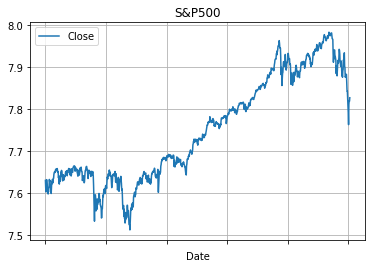

In [13]:
snp_close.plot(grid=True, title='S&P500')

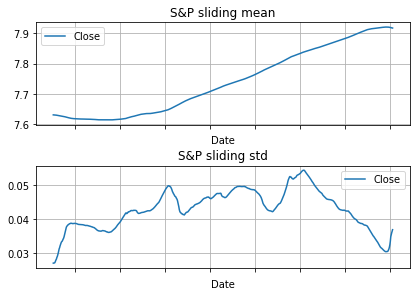

In [14]:
# Sliding window analysis
window = 252 # 252 trading days in a market

fig, axes = plt.subplots(2,1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

# Plot sliding window statistics for prices
snp_close.rolling(window).mean().plot(ax=axes[0], grid=True, title='S&P sliding mean')
snp_close.rolling(window).std().plot(ax=axes[1], grid=True, title='S&P sliding std')

An auto-regressive (AR) process is a process where its future values depends on its past values plus noise, and is mathematically defined as:

\begin{equation}
    x[t] = a_1 x[t-1] + ... + a_p x[t-p] + \eta[t] 
    = \sum_{i=1}^p a_i x[t-i] + \eta[t]
\end{equation}

where the autocorrelation coefficients are found by finding vector $\textbf{a}$, which is estimated using the Yule-Walker equations

\begin{equation}
    \textbf{a} = \textbf{R}_{xx}^{-1}\textbf{r}_{xx}
\end{equation}

where $\textbf{R}_{xx}$ and $\textbf{r}_{xx}$ are formed by the autocorrelation functions such that 

\begin{equation}
    \textbf{R}_{xx} = 
    \begin{vmatrix}
        r_0 & r_{-1} & ... & \eta^2 \\
        r_1 & r_{0} & ... & r_{p-2}\\
        ... & ... & ... & ... \\
        r_{p-1} & r_{p-2} & ... & r_{0}\\
    \end{vmatrix}
    ,
    \textbf{r}_{xx} = 
    \begin{vmatrix}
        r_1 \\
        r_2 \\
        ... \\
        r_{p}\\
    \end{vmatrix}
\end{equation}

The error term from the auto-regressive model can be further modelled as a linear combination of its past values, which forms the moving-average (MA) part of an auto-regressive moving-average (ARMA) model, which is defined as:

\begin{equation}
    x[t] = \sum_{i=1}^p a_i x[t-i] + \sum_{i=1}^q b_i \eta[t-i] + \eta [t]
\end{equation}

In the financial sector in particular, the AR part of the ARMA model aims to explain the momentum and mean reversion effects of the markets (often explained with participation effect), while the MA part captures the "noise" that is caused by exogeneous shocks (such as news) that can't be explained by the past data.

However, ARMA models assumes stationarity in the data, which means the it would perform badly with a signal such as the S&P 500 prices series since there is a strong trend present. For this reason, an ARIMA model is more appropriate since the integrating part (I in ARIMA) applies a differencing operation which removes the elements of non-stationarity. 

### 1.2.2 ARMA Modelling

For this section, an ARIMA(1,0,0) model is used to fit the S&P 500 data, meaning that it is a first order auto-regressive model. This model is suitable for the financial time series because it is often assumed to be a martingale process, where the conditional expectation of next value given all prior values is equal to the present value only.

The AR(1) model fits the function quite well, with the figure below shoing the true vs predicted values and the residual of last 100 days, with an mean absolute residual of 0.005974. Overall, the prediction is a lagged version of the real signal. It is also interesting to see that the residuals are smaller for well-behaved part of the signal. This is also expected since the model does not have a moving average part that models the shocks of exogeneous events which can cause higher volatility.

In addition, the model parameter in this case is 7.740, which is greater than 1. This means that the process is fundamentally explosive and non-stationary, which is to be expected due to the uptrend present in the spx (stability of the AR process is explored in section 3).

In practice, the given AR(1) model makes assumptions that often does not reflect reality. For instance, the process is assumed to be a pure martingale by having an autoregression of order 1, and it is also assumed to be stationary. Finally, effects of shocks is also not modelled by the white noise moving average, which is also not reflective of reality. This suggests that the above model is not really useful in practice.

In [15]:
snp_arma = copy.deepcopy(snp_close)# what does deep copy do?
snp_arma.columns = ['True'] # rename column

In [16]:
# Find the residual
snp_arma['Res'] = ARIMA(snp_arma['True'].values, order=(1,0,0)).fit().resid
snp_arma['Prediction'] = snp_arma['True'] - snp_arma['Res'] 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

MAR:  0.005974467143405074


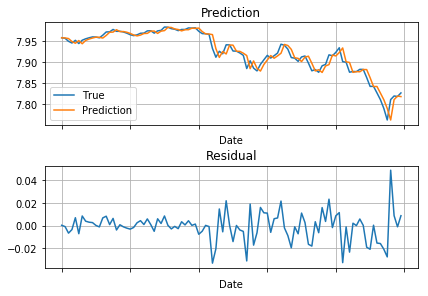

In [17]:
fig, axes = plt.subplots(2,1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

snp_arma['True'][-100:].plot(ax=axes[0])
snp_arma['Prediction'][-100:].plot(ax=axes[0], grid=True, title='Prediction')
axes[0].legend(['True', 'Prediction'])

snp_arma['Res'][-100:].plot(ax=axes[1], grid=True, title='Residual')

print('MAR: ', np.mean(abs(snp_arma['Res'])))

MAR:  0.005974467143405074


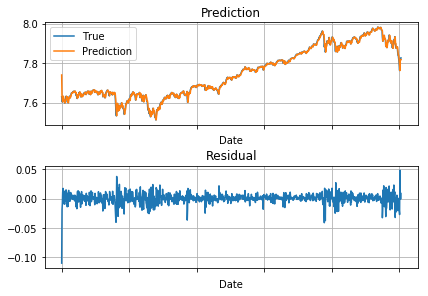

In [18]:
fig, axes = plt.subplots(2,1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

snp_arma['True'].plot(ax=axes[0])
snp_arma['Prediction'].plot(ax=axes[0], grid=True, title='Prediction')
axes[0].legend(['True', 'Prediction'])

snp_arma['Res'].plot(ax=axes[1], grid=True, title='Residual')

print('MAR: ', np.mean(abs(snp_arma['Res'])))

In [19]:
print('Model Parameters: ', ARIMA(snp_arma['True'].values, order=(1,0,0)).fit().arparams)
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMAResults.html

Model Parameters:  [0.99735931]


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

### 1.2.3 ARIMA Modelling

This section will use an ARIMA(1,1,0) to fit the time series, which essentially applies an order-1 AR model as before on an initial dfferencing (of order 1) on the log-price series to remove non-stationarity. Figure below shows that there is a slight improvement for this model(mean absolute residual of 0.005848, which is an improvement of 2%). 

Finally, the AR parameter of this model is -0.008751, which is less than 1, meaning that the returns series is stable and stationary unlike the explosive ARMA model. The parameter is also negative, which means that successive returns tend to be negatively correlated. Finally, the parameter is near 0 in value, which means that there is little correlation between successive returns, and that the model isn't good enough for forecasting since auto-regressive models assumes auto-correlation. Finally, the ARIMA model produces no spikes at the beginning of the time-series unlike the ARMA model due to stationarity.

In [20]:
snp_arma = copy.deepcopy(snp_close)# what does deep copy do?
snp_arma.columns = ['True'] # rename column

In [21]:
# predict using ARIMA (1,1,0)
true = snp_arma['True'][1:]
res = ARIMA(snp_arma['True'].values, order=(1,1,0)).fit().resid
pred = snp_arma['True'][1:] - res

res = pd.Series(data=res, index=true.index)
pred = pd.Series(data=pred, index=true.index)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

MAR:  0.0058479271367899354


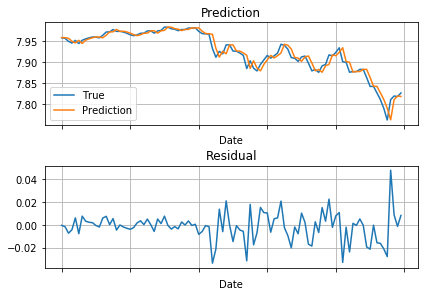

In [22]:
fig, axes = plt.subplots(2,1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

true[-100:].plot(ax=axes[0])
pred[-100:].plot(ax=axes[0], grid=True, title='Prediction')
axes[0].legend(['True', 'Prediction'])

res[-100:].plot(ax=axes[1], grid=True, title='Residual')

print('MAR: ', np.mean(abs(res)))

MAR:  0.0058479271367899354


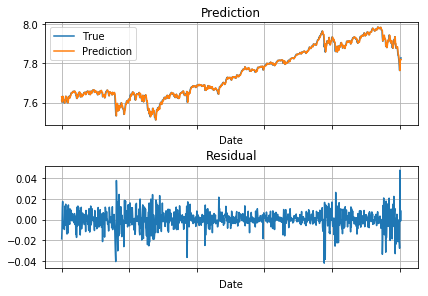

In [23]:
fig, axes = plt.subplots(2,1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

true.plot(ax=axes[0])
pred.plot(ax=axes[0], grid=True, title='Prediction')
axes[0].legend(['True', 'Prediction'])

res.plot(ax=axes[1], grid=True, title='Residual')

print('MAR: ', np.mean(abs(res)))

In [24]:
print('Model Parameters: ', ARIMA(snp_arma['True'].values, order=(1,1,0)).fit().arparams)

Model Parameters:  [-0.00875146]


C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

The residual characteristics of the ARIMA model is slightly better than the ARMA model since the differencing improves upon the non-stationarity of the trend present in the data. However, the performance remains similar since the volatility caused by the shock events is still not captured by the MA term. 

In terms of physical meaning, the ARIMA model helps understand the final signal better. This is because applying the ARIMA model with integrating order of 1 is the equivalent of applying the ARMA model on the time-series differenced once. And since the differencing is applied on the log-prices, this means that the ARIMA model is predicting the next log-return as a function of its past values instead of predicting next log-price. 

\begin{equation}
    {ln(p_t)}-{ln(p_{t-1})} = ln \frac{p_t}{p_{t-1}} = r_{log}
\end{equation}

This therefore also explains why a first order differencing of $ln(p_t)-ln(p_{t-1})$ makes the signal stationary, since the log-returns are normally distributed in the short-term as shown in the histogram from the previous sections. 


### 1.2.4 Log-Prices and ARIMA

As breifly mentioned in the previous section, the ARIMA model applies the ARMA model to the time-series differenced once. This is much more meaningful in the context of log-prices since the difference of log prices is the log-return.

\begin{equation}
r_{log} = ln \frac{p_t}{p_{t-1}} = {ln(p_t)}-{ln(p_{t-1})}
\end{equation}

Therefore, the ARIMA model is fitting an auto regressive model on successive returns, which not only makes more physical sense but also improves the quality of modelling by making it stationary. This is in addition to all the benefits of using log-prices as mentioned in the section 1.1.4. 

In [25]:
snp_arma = copy.deepcopy(snp['Close'].to_frame())# what does deep copy do?
snp_arma.columns = ['True'] # rename column

In [26]:
# predict using ARIMA (1,1,0)
true = snp_arma['True'][1:]
res = ARIMA(snp_arma['True'].values, order=(1,1,0)).fit().resid
pred = snp_arma['True'][1:] - res

true = np.log(true)
pred = pd.Series(data=np.log(pred), index=true.index)
res = pd.Series(data=true-pred, index=true.index)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

The figure below shows the results of ARIMA model applied to the prices series (but brough back to the log space afterwards to make the comparison sensible). For this model, the MAR is of 0.005849, which is about 0.02% worse than the ARIMA applied to log-prices. 

MAR:  0.00584899416990661
Need to compare results in terms of percentage


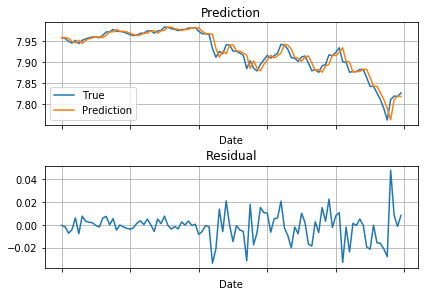

In [27]:
fig, axes = plt.subplots(2,1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

true[-100:].plot(ax=axes[0])
pred[-100:].plot(ax=axes[0], grid=True, title='Prediction')
axes[0].legend(['True', 'Prediction'])

res[-100:].plot(ax=axes[1], grid=True, title='Residual')

print('MAR: ', np.mean(abs(res)))
print('Need to compare results in terms of percentage')

MAR:  0.00584899416990661
Need to compare results in terms of percentage


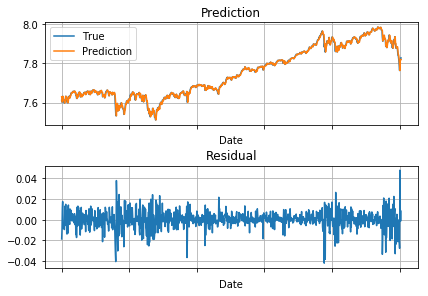

In [28]:
fig, axes = plt.subplots(2,1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

true.plot(ax=axes[0])
pred.plot(ax=axes[0], grid=True, title='Prediction')
axes[0].legend(['True', 'Prediction'])

res.plot(ax=axes[1], grid=True, title='Residual')

print('MAR: ', np.mean(abs(res)))
print('Need to compare results in terms of percentage')

## 1.3 Vector Autoregressive (VAR) Models

### 1.3.1 Concise VAR 

The multivariate extension of the AR model is the vector auto-regressive (VAR) model, where the next time value is dependent on the past values of multiple variables, with the residual being captured by an error term $\textbf{e}_t$ as shown in the equation below. This is particularly useful when multiple time-series exhibit auto-regression characteristics across variables, meaning that there is correlation in time (auto-correlation) and in space (across variables). The VAR(p) process is mathematically defined as:

\begin{equation}
\label{eq:singleperiodvar}
\textbf{y}_t = \textbf{c} + \textbf{A}_1 \textbf{y}_{t-1} + ... + \textbf{A}_p \textbf{y}_{t-p} + \textbf{e}_t
\end{equation}

where $\textbf{y}_i \in \mathbb{R}^{K \text{x} 1}$ for $i$ in $[t-p, t]$, $\textbf{c} \in \mathbb{R}^{K \text{x} 1}$, $\textbf{A}_j \in \mathbb{R}^{K \text{x} K}$ for $j$ in $[1, p]$, and $\textbf{e}_t \in \mathbb{R}^{K \text{x} 1}$.

However, by taking a bases view of the matrix, it is possible to re-write the above model concisely by composing the following matrices:

\begin{equation}
    \textbf{B} = 
    \begin{vmatrix}
        \textbf{c} & \textbf{A}_1 & \textbf{A}_2 & ... & \textbf{A}_p 
    \end{vmatrix}
\end{equation}

\begin{equation}
    \textbf{Z} = 
    \begin{vmatrix}
        1 \\
        \textbf{y}^T_{t-1} \\
        \textbf{y}^T_{t-2} \\
        ... \\
        \textbf{y}^T_{t-p} \\
    \end{vmatrix}
\end{equation}

\begin{equation}
\textbf{U} = \textbf{e}_t
\end{equation}

\begin{equation}
\textbf{Y} = \textbf{y}_t
\end{equation}

Where $\textbf{B} \in \mathbb{R}^{K \text{x} (KP+1)}$, $\textbf{Z} \in \mathbb{R}^{(KP+1) \text{x} 1}$, $\textbf{U} \in \mathbb{R}^{K \text{x} 1}$, and $\textbf{Y} \in \mathbb{R}^{K \text{x} 1}$.

Therefore, a concise matrix form of the VAR model can be written as:

\begin{equation}
\label{eq:concisevar}
\textbf{Y} = \textbf{BZ}+\textbf{U} 
\end{equation}

However, it is possible to generalize the above equation further by extending the above equation to the multi-period case such that multiple $T$ time-steps are modelled. This means add additional columns for additional times steps to $\textbf{Y}$, $\textbf{Z}$, and $\textbf{U}$. This, ways the above equation holds for matrices of dimensions $\textbf{B} \in \mathbb{R}^{K \text{x} (KP+1)}$, $\textbf{Z} \in \mathbb{R}^{(KP+1) \text{x} T}$, $\textbf{U} \in \mathbb{R}^{K \text{x} T}$, and $\textbf{Y} \in \mathbb{R}^{K \text{x} T}$. Hence, equation \ref{eq:singleperiodvar} is a special case of equation \ref{concisevar} for $T=1$. Hence, the generalized matrices are:

\begin{equation}
    \textbf{Y} = 
    \begin{vmatrix}
        \textbf{y}_{t} & \textbf{y}_{t+1} & ... & \textbf{y}_{t+T}\\
    \end{vmatrix}
\end{equation}

\begin{equation}
    \textbf{Z} = 
    \begin{vmatrix}
        1 & 1 & ... & 1\\
        \textbf{y}_{t-1} & \textbf{y}_{t} & ... & \textbf{y}_{t-1+T}\\
        \textbf{y}_{t-2} & \textbf{y}_{t-1} & ... & \textbf{y}_{t-2+T}\\
        ... & ... & ... & ... \\
        \textbf{y}_{t-p} & \textbf{y}_{t-p+1} & ... & \textbf{y}_{t-p+T}\\
    \end{vmatrix}
\end{equation}

\begin{equation}
    \textbf{U} = 
    \begin{vmatrix}
        \textbf{e}_{t} & \textbf{e}_{t+1} & ... & \textbf{e}_{t+T}\\
    \end{vmatrix}
\end{equation}

### 1.3.2 Optimal VAR Coefficients 

To find the solution to the linear equation $\textbf{Y} = \textbf{BZ}+\textbf{U}$, the least-squares method is used to minimize the squared elements of $\textbf{U}$, since it essentially represents the error in the model. Therefore, this problem can be set up as an optimization problem with the following objective function $J(\textbf{B})$:

\begin{equation}
J(\textbf{B}) = (\textbf{BZ} - \textbf{Y})(\textbf{BZ} - \textbf{Y})^T
\end{equation}

\begin{equation}
J(\textbf{B}) = \textbf{B}\textbf{Z}\textbf{Z}^T\textbf{B}^T-2\textbf{Y}\textbf{Z}^T\textbf{B}^T + \textbf{Y}\textbf{Y}^T
\end{equation}

We can optimize the problem by setting the derivative of $J(\textbf{B})$ to zero, which yields:

\begin{equation}
\frac{\delta J(\textbf{B})}{\delta \textbf{B}} = 2\textbf{B}\textbf{Z}\textbf{Z}^T-2\textbf{Y}\textbf{Z}^T = 0
\end{equation}

\begin{equation}
\textbf{B}\textbf{Z}\textbf{Z}^T=\textbf{Y}\textbf{Z}^T 
\end{equation}

\begin{equation}
\textbf{B}_{opt}=\textbf{Y}\textbf{Z}^T (\textbf{Z}\textbf{Z}^T)^{-1}
\end{equation}


### 1.3.3  Eigenvalues of VAR

Consider a VAR(1) process, that is:

\begin{equation}
\textbf{y}_t = \textbf{A}\textbf{y}_{t-1} + \textbf{e}_t
\end{equation}

\begin{equation}
\textbf{y}_{t-1} = \textbf{A}\textbf{y}_{t-2} + \textbf{e}_{t-1}
\end{equation}

\begin{equation}
\textbf{y}_{t-2} = \textbf{A}\textbf{y}_{t-3} + \textbf{e}_{t-2}
\end{equation}

\begin{equation}
...
\end{equation}

The equation for $\textbf{y}_t$ can be re-written as:

\begin{equation}
\textbf{y}_t = \textbf{A}\textbf{y}_{t-1} + \textbf{e}_t
\end{equation}

\begin{equation}
\textbf{y}_t = \textbf{A}(\textbf{A}\textbf{y}_{t-2}+\textbf{e}_{t-1}) + \textbf{e}_t
\end{equation}

\begin{equation}
\textbf{y}_t = \textbf{A}^2\textbf{y}_{t-2}+\textbf{A}\textbf{e}_{t-1} + \textbf{e}_t
\end{equation}

\begin{equation}
...
\end{equation}

\begin{equation}
\textbf{y}_t = \textbf{A}^p \textbf{y}_{t-p} + \sum_{i=0}^{p-1} \textbf{A}^i \textbf{e}_{t-i}
\end{equation}

Since the eigenvalues of matrix $\textbf{A}$ follows the property $\textbf{A}^p \textbf{v} = \lambda^p \textbf{v}$, for the VAR model to be stable the eigenvalues of the matrix $\textbf{A}$ must be less than 1 in absolute value such that $lim_{p -> \infty} \lambda^p = 0$, otherwise the power will explode in value. 

### 1.3.4 VAR Portfolio Analysis I

In [29]:
# Load data
df = pd.read_csv(files_path+'snp_allstocks_2015_2019.csv', header=0, index_col=0)
info = pd.read_csv(files_path+'snp_info.csv', index_col=0)

In [30]:
# Select a subset of tickers to analyse
tickers = ['CAG', 'MAR', 'LIN', 'HCP', 'MAT']
stocks = df[tickers]

# Detrend using a moving average of 66 (3*22 i.e. one quarter)
stocks_ma = stocks.rolling(window=66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

This section will explore how the VAR models can be used for portfolio construction. First, the closing price of assets CAG, MAR, LIN, HCP, MAT are examined. The price series is detrended by subtracing the prices series from their moving average of 66 data points (number of trading days in a quarter) to fabricate zero-mean stationary time serieses, which are plotted below. However, because the LIN contains very few data point, most of the time series is dropped.

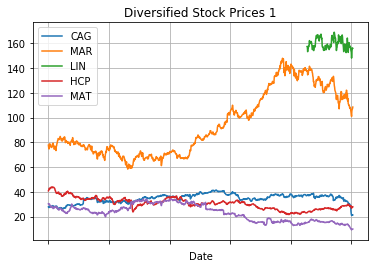

In [31]:
stocks.plot(grid=True, title='Diversified Stock Prices 1')

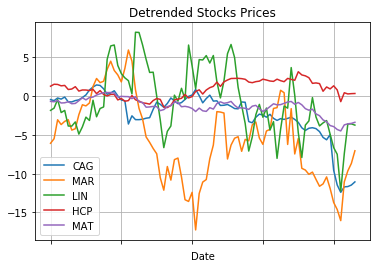

In [32]:
stocks_detrended.plot(grid=True, title='Detrended Stocks Prices')

After fitting the above 5 price series with a first order VAR model, the following paramters were obtained:

In [33]:
# Fit VAR model
model = VAR(stocks_detrended)
results = model.fit(1)

# Print the results for the parameters grid
results.params[1:]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


CAG       MAR       LIN       HCP       MAT
L1.CAG  0.872786  0.113179 -0.281265  0.011912  0.058776
L1.MAR -0.063745  0.895820 -0.184820 -0.005004  0.022917
L1.LIN  0.000134 -0.111678  0.704023  0.004982 -0.025557
L1.HCP -0.084776 -0.083831 -0.401417  0.931708 -0.046406
L1.MAT  0.643072  0.094931  2.033036 -0.012884  0.802974

The table above shows the parameters grid of the fitted VAR(1) model. As expected, the diagonal of the above matrix contains the highest values, which implies that the time series tends to be positively auto-correlated with its lagged value, but not so much with other assets (as they are near 0 or negative). The relationship between the paramters above and correlation is intuitive since positive auto-regression parameters of order 1 implies past prices positively influences future prices and viceversa.

This is also shown in the figure below which plots the time-series value of CAG against its own lagged value (with VAR parameter of 0.873, correlation coefficient of 0.966), showing a strong linear relationship that reflects the high diagonal values shown in the table above. Conversely LIN and lagged HCP tend to be inversely correlated, which is reflected in its negative parameter value in the table above (VAR parameter of -0,401, correlation coefficient of -0.284).



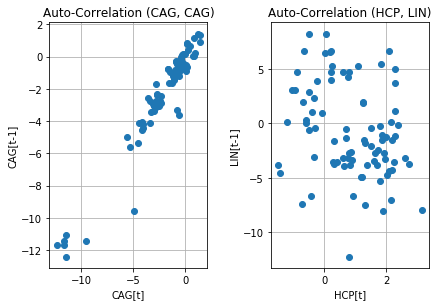

In [34]:
fig, axes = plt.subplots(1,2)
fig.tight_layout()
fig.subplots_adjust(wspace=0.4)

axes[0].plot(stocks_detrended['CAG'][:-1], stocks_detrended['CAG'][1:], 'o')
axes[0].set_xlabel('CAG[t]')
axes[0].set_ylabel('CAG[t-1]')
axes[0].set_title('Auto-Correlation (CAG, CAG)')
axes[0].grid()

axes[1].plot(stocks_detrended['HCP'][:-1], stocks_detrended['LIN'][1:], 'o')
axes[1].set_xlabel('HCP[t]')
axes[1].set_ylabel('LIN[t-1]')
axes[1].set_title('Auto-Correlation (HCP, LIN)')
axes[1].grid()

In [35]:
print('Fig1 correlation: ', stats.pearsonr(stocks_detrended['CAG'][:-1], stocks_detrended['CAG'][1:]))
print('Fig2 correlation: ', stats.pearsonr(stocks_detrended['HCP'][:-1], stocks_detrended['LIN'][1:]))

Fig1 correlation:  (0.9661648938654335, 3.3004386815289733e-51)
Fig2 correlation:  (-0.2840845532254369, 0.008030282143284113)


The above matrix therefore can be interpreted almost as a covaraince matrix. Hence, by applying the eigenvalue and eigenvector analysis, it is possible to extract the direction and magnitude of highest variance within the variables (with the greatest eigenvalue). However, even if the VAR parameters and covariance matrix share similar characteristics, this analysis fundamentally differs from PCA in many ways. For instance, the above matrix is asymmetric, which yields eigenvalues that are immaginary. 

Overall, the eigenvalues of the above matrix average about 0.846 in magnitude, with the highest being 1.006 and the smallest being 0.726. Therefore, the assets tend to be uncorrelated with each other, which is expected since they are from different industry sectors as shown in the table below. Therefore, it would make sense to construct a portfolio using these stocks (the reason is explored in the next section).

In [36]:
info.set_index('Symbol').T[tickers].loc['GICS Sector'].to_frame()

GICS Sector
Symbol                        
CAG           Consumer Staples
MAR     Consumer Discretionary
LIN                  Materials
HCP                Real Estate
MAT     Consumer Discretionary

In [37]:
A = results.params[1:].values
eigA, _ = np.linalg.eig(A)
print(eigA)

[0.71449288+0.12927613j 0.71449288-0.12927613j 1.00635964+0.j
 0.86051894+0.j         0.91144512+0.j        ]


In [38]:
np.mean(abs(eigA)), np.min(abs(eigA)), np.max(abs(eigA))

(0.8461023111455764, 0.7260939285436445, 1.0063596404610191)

The above data however contains the stock LIN which has less than 20% of the data compared to other stocks formed in the portfolio. The same analysis is carried out with the APD, which is in the same GICS sub industry as LIN but with more data. Eigen-value analysis however shows the same results with the diagonal containing the highest values, while other coefficients are closer to zero. The magnitude of eigenvalues in this case have average about 0.966, with the minimum being 0.942 and max being 0.979, which means that they are even more un-correlated than the example before.


In [39]:
# Select a subset of tickers to analyse
tickers = ['CAG', 'MAR', 'APD', 'HCP', 'MAT']
stocks = df[tickers]

# Detrend using a moving average of 66 (3*22 i.e. one quarter)
stocks_ma = stocks.rolling(window=66).mean()
stocks_detrended = stocks.sub(stocks_ma).dropna()

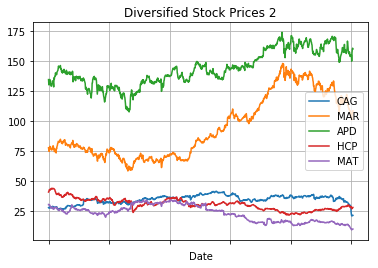

In [40]:
stocks.plot(grid=True, title='Diversified Stock Prices 2')

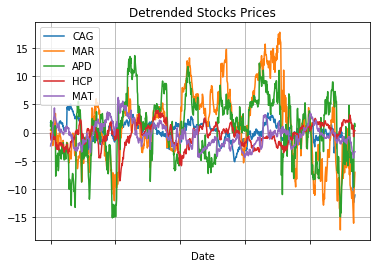

In [41]:
stocks_detrended.plot(grid=True, title='Detrended Stocks Prices')

In [42]:
# Fit VAR model
model = VAR(stocks_detrended)
results = model.fit(1)

# Print the results for the parameters grid
results.params[1:]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


CAG       MAR       APD       HCP       MAT
L1.CAG  0.976601  0.003245 -0.043526  0.011506  0.001898
L1.MAR  0.002488  0.966825  0.019019  0.000366 -0.000140
L1.APD -0.001881  0.006991  0.945082 -0.001559 -0.002263
L1.HCP -0.029259 -0.071794 -0.023169  0.972232 -0.008258
L1.MAT  0.013399 -0.025500  0.014128 -0.010201  0.967046

In [43]:
A = results.params[1:].values
eigA, _ = np.linalg.eig(A)
print(eigA)

[0.97846933+0.01828052j 0.97846933-0.01828052j 0.94228761+0.j
 0.95134609+0.j         0.97721328+0.j        ]


In [44]:
np.mean(abs(eigA)), np.min(abs(eigA)), np.max(abs(eigA))

(0.9656254261485293, 0.9422876091795223, 0.9786400757013636)

### 1.3.5 VAR Portfolio Analysis II

The same eigenvalue analysis is carried out by grouping stocks of same sectors together. The min, mean and max eigenvalue magnitudes are presented in the table below. As expected, about 70% of the portfolio formed by grouping stocks from the same sector obtained eigenvalues for their VAR parameters matrix which are smaller than the ones mentioned in the previous section (the eigenvalues are all smaller for the case of APD instead of LIN). This means that the amount of variation in a given set of stocks is little, which implies that they tend to be more correlated in movement with each other, hence varying little in differences. 

In [45]:
eig_df = pd.DataFrame(columns=info['GICS Sector'].unique(), index=['min eigenvalue', 'mean eigenvalue', 'max eigenvalue'])
returns = pd.DataFrame(columns=info['GICS Sector'].unique(), index=['return mean', 'return std'])

for sector in info['GICS Sector'].unique():
    
    # form portfolio of tickers from the same sector
    tickers = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    stocks = df[tickers]
    
    # Detrend using a moving average of 66 (3*22 i.e. one quarter)
    stocks_ma = stocks.rolling(window=66).mean()
    stocks_detrended = stocks.sub(stocks_ma).dropna()

    # Fit VAR model
    model = VAR(stocks_detrended)
    results = model.fit(1)

    # Analyse the parameters
    A = results.params[1:].values
    eigA, _ = np.linalg.eig(A)
    
    eig_df[sector]['min eigenvalue'] = np.min(abs(eigA))
    eig_df[sector]['mean eigenvalue'] = np.mean(abs(eigA))
    eig_df[sector]['max eigenvalue'] = np.max(abs(eigA))

    # calculate sector return and standard deviation 
    sector_returns = stocks.pct_change().dropna().mean(1)
    returns[sector]['return mean'] = sector_returns.mean()
    returns[sector]['return std'] = sector_returns.std()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so wi

In [46]:
eig_df.T

min eigenvalue mean eigenvalue max eigenvalue
Industrials                  0.371246        0.763932       0.991721
Health Care                 0.0921573         0.62144       0.994153
Information Technology       0.374081        0.809351       0.992738
Communication Services       0.752488        0.926293       0.982263
Consumer Discretionary       0.447563        0.810433        0.99065
Utilities                   0.0421154        0.599877       0.985648
Financials                   0.152575        0.631218        1.00434
Materials                    0.137838        0.621833       0.991744
Real Estate                  0.763563        0.919369       0.982785
Consumer Staples             0.546458        0.852121       0.991508
Energy                       0.825707        0.930601       0.985577

Generally, it is not advisable to build a portfolio by grouping the stocks together by their sector, this is because the set of assets chosen will have exposure to the same type of risks that can affect the particular sector (e.g. 2008 mortgage backed securities crisis affected the real-estate sector way more than other ones), which means that they are more correlated with each other.

The diversification premium of the portfolio is achieved when the stocks are un-correlated with each other, since the return of the portfolio is $r_p = \sum_{i=1}^n w_i r_i$ and the standard deviation is $\sigma^2 = \sum_{i,j=1}^n w_i \sigma_{ij} w_j$ where $w_i, r_i$ is the weight and the return of an asset while $\sigma_{ij}$ is the covariance of returns between two assets.

For instance, take 2 randomly chosen stocks, the return of the portfolio is given by $r_p= w_1 r_1 + (1-w_1) r_2 $, whereas the standard deviation is $\sigma_p = \sqrt{w_1^2 \sigma_{1}^2 + 2 w_1 (1-w_1) \rho \sigma_1 \sigma_2 + (1-w_1)^2 \sigma_2^2}$. For simplicity, assume that both assets have return $r$ and standard deviation $\sigma$ and that $w_1 = 0.5$. The Sharpe ratio $\frac{r_p}{\sigma_p}$ for perfectly correlated portfolio with $\rho=1$ is $\frac{r}{\sigma}$, where as for perfectly uncorrelated (identically and independently distributed assets) portfolio with $\rho=1$ is $\sqrt{2} \frac{r}{\sigma}$ (generally, for $n$ iid assets, the Sharpe ratio is $\sqrt{n} \frac{r}{\sigma}$). 

Therefore, by forming a portfolio of different uncorrelated assets, it is possible to increase the Sharpe ratio, which means that there is more return per unit of risk taken. This is shown in the table below, where the Sharpe ratio is calculated for portfolios by sector and by aggregating the entire S&P500 using daily returns, where the Sharpe ratio of the portfolio is among the highest.

In [47]:
df = df.dropna(1)

In [48]:
# Form Sector-wise portfolios
portfolios = pd.DataFrame(columns = info['GICS Sector'].unique())

for sector in info['GICS Sector'].unique():
    
    # form portfolio of tickers from the same sector
    tickers_tmp = info.loc[info['GICS Sector']==sector]['Symbol'].tolist()
    tickers = [ticker for ticker in tickers_tmp if df.columns.__contains__(ticker)]
    
    stocks = df[tickers].dropna()
    
    norm_ensemble = stocks / stocks.iloc[0,:]
    
    portfolios[sector] = norm_ensemble.mean(1)

In [49]:
# Form aggregate portfolio
stocks = df
norm_ensemble = stocks / stocks.iloc[0,:]
portfolios['S&P500 Portfolio'] = norm_ensemble.mean(1)

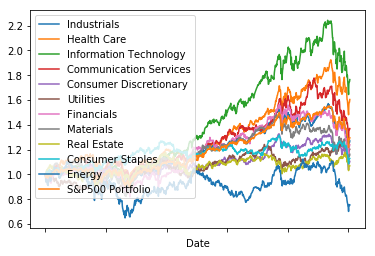

In [50]:
portfolios.plot()

In [51]:
# create returns dataframe
returns = pd.DataFrame(columns=portfolios.columns, index=['return mean','return std', 'return sharpe'])

In [52]:
for sector in portfolios.columns:
    ts = portfolios[sector].pct_change().dropna()
    returns[sector]= [ts.mean(), ts.std(), ts.mean()/ts.std()]

In [53]:
returns.T.sort_values('return sharpe', ascending=False)

return mean  return std  return sharpe
Information Technology     0.000635    0.011749       0.054007
Health Care                0.000526    0.010517       0.049984
Communication Services     0.000374    0.011035       0.033905
S&P500 Portfolio           0.000297    0.008799       0.033719
Industrials                0.000283    0.009521       0.029746
Financials                 0.000274    0.011037       0.024866
Utilities                  0.000229    0.009506       0.024100
Materials                  0.000208    0.010765       0.019299
Consumer Staples           0.000152    0.007968       0.019127
Consumer Discretionary     0.000146    0.009703       0.015098
Real Estate                0.000113    0.009610       0.011740
Energy                    -0.000150    0.016196      -0.009262

# 2. Bond Pricing, CAPM and APT

In [54]:
# Import relevant libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

## 2.1. Examples of Bond Pricing

### 2.1.1. Effective Rates

Consider the following example: An investor receives USD $1100$ in one year in return for an investment of USD $1000$ now, gaining an effective rate $r_{eff}$ of return of 10%. Under different compounding intervals, the nominal interest rates per annum will vary accordingly. Formally, the relationship between the effective interest rates $r_{eff}$ and the nominal interest rate $r$ is $ 1+r_{eff} = (1+\frac{r}{m})^m $ where $m$ is the number of compounding periods in a year. This means that $r=m(1+r_{eff})^{\frac{1}{m}}-m$. 

Therefore, for (a) annual, (b) semi-annual and (c) monthly compounding ($m=1, 2, 12$ respectively), the nominal rate of return per annum for an effective rate of 10% are:

    (a) 10.00% 
    (b) 9.76%
    (c) 9.57%

Finally, up to the $k^{th}$ period, the compounding is $ (1+\frac{r}{m})^k = (1+\frac{r}{m})^{mt}$, and by using (d) continous compounding where $m$ approaches infinity, the rate becomes $lim_{m->\infty} (1+\frac{r}{m})^{mt} = e^{rt}$. Hence, the continous compounding rate of return after 1 year is $r=ln(1+r_{eff})$ which is:

    (d) 9.53%

### 2.1.2. Equivalent Rates  (I)

If $r = 15\%$ per annum for monthly compounding, the effective rate is $r_{eff}=(1+\frac{r}{12})^{12}-1=16.08\%$. The equivalent nominal rate for continous compounding according to the equation in section 2.1.1. is therefore $r=ln(1+0.1608)=14.91\%$

### 2.1.3. Equivalent Rates (II)

If $r = 12\%$ for continous compounding, the effective rate is $r_{eff}=e^r-1=12.75\%$. The equivalent nominal rate for quarterly compounding is therefore $r=4((1+r_{eff})^{\frac{1}{4}}-1)=12.18\%$. In terms of cash flow, this would generate for each quarter USD $30.45, 31.38, 32.33, 33.32$ for an initial investment of USD $1000$.

## 2.2. Forward Rates

### 2.2.1. Forward Rates Equivalent

#### 2.2.1.a. Comparison Principle

For the arbitrage opportunity to not exist, the equivalence $(1+r_2)^2=(1+r_1)(1+f_{1,2})$ must hold. This can be generalized to $(1+r_j)^j=(1+r_i)^i(1+f_{i,j})^{j-i}$ and is called the implied forward rate. Therefore, the extra earnings has no additional benefits as it is the market expectation of what the 1 year sport rate will be next year. The investor should be neutral about investing for 1 year with $r_1$ and 2 years with $r_2$. 

#### 2.2.1.b. Implied and Market Forward Rates

On choosing between investing periods, the investor should consider the opportunity cost of investing elsewhere and liquidity rather than the rates offered for different investment periods, as the market expectation of the next year's spot rates are already included in the rates. This implied forward rate should be rather close to the market forward rate, which can be slightly different due to market imperfections.

#### 2.2.1.c. Advantages and Disadvantages of Forward Rates

The forward rate $f_{1,2}$ is naturally higher than the rates $r_1$ and $r_2$ since the investor is taking the risk of future interest rates changes that can potentially impact the investment, which is both the advantage and disadvantage of forward rates since the rates can change for the better or worse.

#### 2.2.1.d. Investment Period Changes

To go to 2 year investments after 1 year, the rates will change according to the market expectations and can be calculated with the implied forward rate equation in section 2.2.1.a. using the current spot rate curves.

## 2.3. Duration of a Coupon- Bearing Bond

### 2.3.1. Duration

#### 2.3.1.a. Macaulay Duration

\begin{equation}
    D=\sum_k t_k \frac{PV_k}{PV_{tot}}
\end{equation}

The Macaulay Duration $D$ as defined in the equation above is a measure of sensitivity of the bond price relative to change in yields. For the bond detailed in the table below, $D$ is simply the sum of the last row's elements, which is $6.76$. Note that for zero-coupon bounds, the duration is the same as the maturity date.

In [55]:
bonddf = pd.DataFrame(columns=['year 1','year 2','year 3','year 4','year 5','year 6','year 7','Total'],
                      index=['Payment','PV_k','PV_k/PV_tot','t_k*PV_k/PV_tot'])
bonddf.loc['Payment'] = [10,10,10,10,10,10,1010,1070]
bonddf.loc['PV_k'] = [9.52,9.07,8.64,8.23,7.84,7.46,717.79,768.55]
bonddf.loc['PV_k/PV_tot'] = [0.0124,0.0118,0.0112,0.0107,0.0102,0.0097,0.0934,1]
bonddf.loc['t_k*PV_k/PV_tot'] = [0.0124,0.0236,0.0337,0.0428,0.0510,0.0583,6.5377,6.7595]

bonddf

year 1  year 2  year 3  year 4  year 5  year 6  year 7  \
Payment              10      10      10      10      10      10    1010   
PV_k               9.52    9.07    8.64    8.23    7.84    7.46  717.79   
PV_k/PV_tot      0.0124  0.0118  0.0112  0.0107  0.0102  0.0097  0.0934   
t_k*PV_k/PV_tot  0.0124  0.0236  0.0337  0.0428   0.051  0.0583  6.5377   

                  Total  
Payment            1070  
PV_k             768.55  
PV_k/PV_tot           1  
t_k*PV_k/PV_tot  6.7595

#### 2.3.2.b. Modified Duration 

\begin{equation}
    D_m=\frac{1}{P(\lambda_0)} \frac{d P(\lambda)}{d \lambda} \text{ for } \lambda=\lambda_0 
\end{equation}

Modified duration $D_m$ is another measure of the bond sensitivity defined in the equation above, which is the derivative of the price-yield curve normalized by its price, which comes from the Taylor's series approximation of the price-yield curve. $D_m$ can be proved to be related to the Macaulay duration as $D_m = \frac{D}{1+\frac{y}{m}}$.

Given the yield $y$ of $5\%$, $D_m = \frac{D}{1+\frac{y}{m}} = 6.4376\%$ where $m=1$ since the payments are annual. This value is slightly lower than the Macaulay duration due to the yield. Also, note that the two measures of duration would be the same under continous compounding since $m$ will tend to infinity.

#### 2.3.1.c. Advantages of Duration

The bonds with longer time to maturity are more sensitive to the change in yield due more coupon payments, which makes pension plans highly volatile. For instance, consider the above bond where yield increases by 1%. Approximately, the equation $\frac{\Delta P}{P} \approx -D_m \Delta y$ holds, which implies a drop of 6.44%. This however can be overcome through Immunization, which means matching the desired price and duration of a bond portfolio via $P=\sum_i n_i P_i$ and $D=\sum_i n_i \frac{P_i}{P} D_i$ where $i$ denotes the $i^{th}$ bond, $P$ the price, $n$ the amount and $D$ the duration (Macaulay or Modified).

In theory, the Taylor's series approximation can be expanded to $2^{nd}$ order terms (bond convexity) and higher order terms and match as many terms as possible.

## 2.4. Capital Asset Pricing Model (CAPM) and Arbitrage Pricing Theory (APT)

This section explores the application of CAPM and APT using the daily return of 157 European companies.

CAPM is an extension of the modern portfolio theory which prices individual assets in the presence of a risk-free asset, relating their rate of return to their beta/systematic risks (the risks that can't be diversified away). The CAPM is formulated as $E[r_i]=r_f + \beta (E[r_m]-r_f)$, where $r_i$ is the return of the given company, $r_m$ is the market return, $r_f$ is the risk free rate and $\beta = \frac{cov(r_i, r_m)}{var(r_m)}$. Without taking the expectation, the CAPM is $r_i=r_f + \beta (r_m-r_f) + \epsilon_i $, where $\epsilon_i$ is an uncorrelated zero-mean company specific risk random variable that can be diversified away since $E[\epsilon_i]=0$.

APT is an extension of CAPM which makes fewer assumtpions. The main difference is that instead of pricing the asset according to its systematic risk, it uses multiple macroecnomic and specific factors (size of the company, momentum, etc.) to decompose the return of a given asset. APT is formulated as $r_i=\alpha_i + \sum_j \beta_{ij} F_j + \epsilon_i$ where $\alpha_i$ is the excess return, $\beta_{ij}$ is the exposure to the $j^{th}$ factor $F_j$ of the $i^{th}$ company, and the $\epsilon_i$ has the same definition from CAPM.

### 2.4.1. Non-Weighted Market Return

This section will estimate the market return as the average of company returns. In terms of data pre-processing, since there are some missing data present in the file, the companies with missing values are eliminated from the dataset, hence working with 141 companies in total. Then, the non-weighted market return is calculated by simply averaging the returns of all the companies per day. The returns are plotted in the figure below, with an average daily return of 0.004% and standard deviation of 0.00665, while the weighted volatility (1/Sharpe ratio, which is the standard deviation weighted by the average return) is around 141.

Market return mean:  4.720252923319892e-05 Market return stddev:  0.006650324555998098
1/Sharpe:  140.889157086115


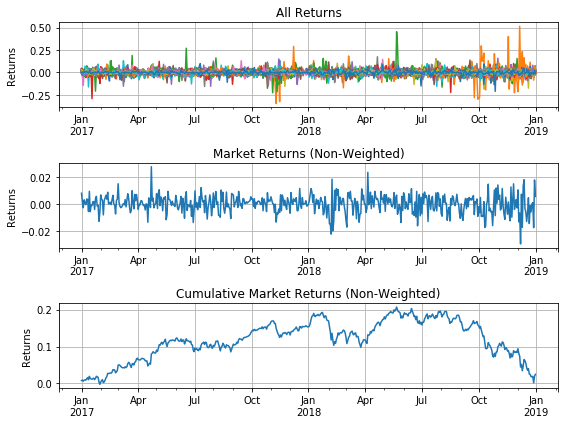

In [56]:
# Read data
df = pd.read_csv('DataSource/fsp_case_31_BSD.csv', index_col=0,header=[0 ,1]) 

# Data pre-processing
rs = df['ret'].copy().dropna(1) # simple data pre-processing
rs.index = pd.to_datetime(rs.index) # Seth the index to date time type
rs = rs.sort_index() # sort by time
rm_nw = rs.mean(1) # market return (non-weighted)

# Plot the figures
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
rs.plot(legend=False, ax=ax1, title='All Returns', grid=True).set_ylabel('Returns')
rm_nw.plot(legend=False, ax=ax2, title='Market Returns (Non-Weighted)', grid=True).set_ylabel('Returns')
rm_nw.cumsum().plot(legend=False, ax=ax3, title='Cumulative Market Returns (Non-Weighted)', grid=True).set_ylabel('Returns')
fig.set_size_inches(8,6)
fig.tight_layout()
print('Market return mean: ', rm_nw.mean(), 'Market return stddev: ', rm_nw.std())
print('1/Sharpe: ', rm_nw.std()/rm_nw.mean())

### 2.4.2. Non-Weighted Rolling Beta

Here the $\beta$ is calculated on a rolling basis of 22 days window (1 trading month). This is done by calculating the covariance of each of the asset and the market normalized by the market variance. The rolling $\beta$ is shown in the figure below. As shown in the histogram, most of the beta center around 1 meaning that most assets are positively correlated with the overall market (the market factor explains most of the individual returns), with a standard deviation of 0.71, which demonstrates low volatility overall. Finally, the peaks in the rolling beta graph are examples of idiosyncratic shocks associated with $\epsilon$ discussed before, which can be due to news and other factors. Overral the zero-mean distribution means that these are risks that can be diversified away.

Text(0,0.5,'Beta')

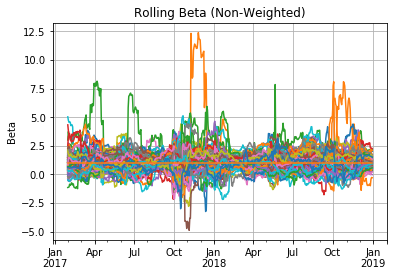

In [57]:
# Create a matrix of returns 
allr_nw = rs.copy() # make a copy of company returns
allr_nw['market'] = rm_nw.copy() # add additional market returns to the dataframe

# initialize the rolling beta dataframe
betadf_nw = pd.DataFrame(columns=allr_nw.columns) 

w = 22 # set rolling window to 22
for t in allr_nw.index[w-1:]: # step through the time
    
    rcovs = allr_nw[:t].iloc[-w:].cov() # calculate the covariance matrix
    betas = rcovs['market']/rcovs['market']['market'] # calculate betas 
        
    betadf_nw.loc[t] = betas # add to dataframe

# plot the rolling beta
betadf_nw.plot(legend=False, grid=True, title='Rolling Beta (Non-Weighted)').set_ylabel('Beta')

mean:  1.0
std:  0.7081043669711367


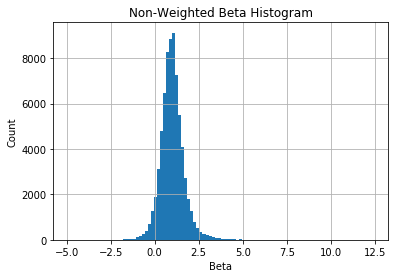

In [58]:
# Overall distribution
plt.hist(betadf_nw.values.reshape(-1), bins=100)
plt.grid()
plt.ylabel('Count')
plt.xlabel('Beta')
plt.title('Non-Weighted Beta Histogram')

print('mean: ', np.mean(betadf_nw.values.reshape(-1)))
print('std: ', np.std(betadf_nw.values.reshape(-1)))

### 2.4.3. Weighted Market Return

The weighted market return is calculated as $R_m=\sum_i r_i \frac{mcap_i}{\sum_i mcap_i}$. This forms a portfolio that is weighted relative to market capitalization. This is hence forming a market portfolio, which according to the one-fund theorem, can form any efficient portfolio in the Markowitz sense (optimal mean-variance portfolio) by combining it with a risk-free asset. 

The figure below shows the weighted market returns, which has a average return of 0.018% and standard deviation of 0.00660. Note that the 1/Sharpe ratio in this case is 35, which is much smaller than the non-weighted returns case of 141. This is because the small-cap stocks are riskier in nature, but their volatility is less expressed in the market portfolio since the exposure is inversely proportional to the market capitalization. 

Market return mean:  0.00018841990142144186 Market return stddev:  0.006599318685834854
1/Sharpe:  35.02453103971247


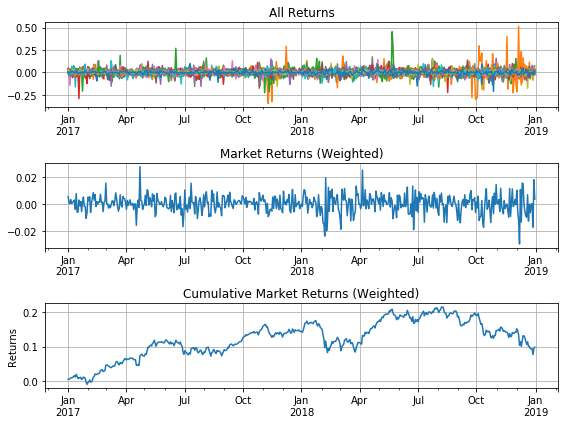

In [59]:
# Get the market cap
mcap = df['mcap'].copy() # make a copy
mcap.index = pd.to_datetime(mcap.index) # set the index to datetime type 
mcap = mcap[rs.columns] # select the mcap values for existing non zero returns

# get the weights 
ws = mcap.divide(mcap.sum(1), 0)

# get the weighted market return
allr_w = ws*rs.copy()
rm_w = allr_w.sum(1)

# plot the returns
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
rs.plot(legend=False, ax=ax1, title='All Returns', grid=True)
rm_w.plot(legend=False, ax=ax2, title='Market Returns (Weighted)', grid=True)
rm_w.cumsum().plot(legend=False, ax=ax3, title='Cumulative Market Returns (Weighted)', grid=True).set_ylabel('Returns')
fig.set_size_inches(8,6)
fig.tight_layout()

print('Market return mean: ', rm_w.mean(), 'Market return stddev: ', rm_w.std())
print('1/Sharpe: ', rm_w.std()/rm_w.mean())

### 2.4.4 Weighted Rolling Beta

The rolling $\beta$ calculation is repeated for the cap weighted market returns. The figure below shows the rolling cap weighted beta and the overall distribution. This histogram too has a smaller standard deviation (0.69 instead of 0.71), which is expected due to the risky nature of small-cap companies.

Text(0,0.5,'Beta')

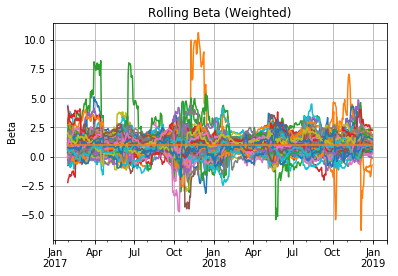

In [60]:
# Create a matrix of returns 
allr_w = rs.copy() # make a copy of company returns
allr_w['market'] = rm_w.copy() # add additional market returns to the dataframe

# initialize the rolling beta dataframe
betadf_w = pd.DataFrame(columns=allr_w.columns) 

w = 22 # set rolling window to 22
for t in allr_w.index[w-1:]: # step through the time
    
    rcovs = allr_w[:t].iloc[-w:].cov() # calculate the covariance matrix
    betas = rcovs['market']/rcovs['market']['market'] # calculate betas 
        
    betadf_w.loc[t] = betas # add to dataframe

# plot the rolling beta
betadf_w.plot(legend=False, grid=True, title='Rolling Beta (Weighted)').set_ylabel('Beta')

mean:  0.9616577418388087
std:  0.6940217680471458


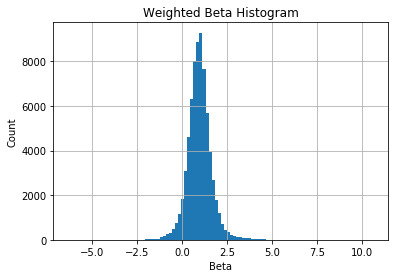

In [61]:
# Overall distribution
plt.hist(betadf_w.values.reshape(-1), bins=100)
plt.grid()
plt.ylabel('Count')
plt.xlabel('Beta')
plt.title('Weighted Beta Histogram')

print('mean: ', np.mean(betadf_w.values.reshape(-1)))
print('std: ', np.std(betadf_w.values.reshape(-1)))

### 2.4.5. Arbitrage Pricing Theory

#### 2.4.5.a. Factor Returns Estimation

For this section, the APT is assumed to hold for a 2-factors model as $r_i = \alpha + \beta_{m,i} R_m + \beta_{s,i} R_s + \epsilon_i$, where $\alpha$ is the excess return (which can be interpreted as the risk-free return), $\beta_{m,i}$ is the exposure to the return $R_m$ which is the return specific to the market return factor, while $\beta_{s,i}$ is the exposure to the return $R_s$ which is the return specific to the market capitalization factor and $\epsilon_i$ is the specific return. Here the exposure to size is assumed to be $\beta_{s,i}=ln(size)$. 

The Ordinary Least Squares method is used in this case to estimate one $\alpha$, one $R_m$ and one $R_s$ per day which satisfies the following matrix multiplication:

\begin{equation}
    \textbf{r} = \textbf{X} \textbf{b} + \textbf{e}
\end{equation}

\begin{equation}
    \begin{vmatrix}
        r_1 \\
        r_2 \\
        ... \\
        r_n \\
    \end{vmatrix} =  
    \begin{vmatrix}
        1 & \beta_{m,1} & \beta_{s,1}\\
        1 & \beta_{m,2} & \beta_{s,2}\\
        ... & ... & ... \\
        1 & \beta_{m,n} & \beta_{s,n}\\
    \end{vmatrix}
    \begin{vmatrix}
        \alpha \\
        R_m \\
        R_s \\
    \end{vmatrix} +
    \begin{vmatrix}
        \epsilon_1 \\
        \epsilon_2 \\
        ... \\
        \epsilon_n \\
    \end{vmatrix}     
\end{equation}

Hence, the solution to the OLS problem above is $\hat{\textbf{b}} = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T \textbf{r}$, which is computed for everyday.

In [62]:
# Generate a table of returns per company over time
ri = rs.copy() # make a copy of returns
ri = ri.loc[betadf_w.index] # select only the returns that have the market beta calculated already
print('ri: ', ri.shape)

# Get the market beta
bm = betadf_w.iloc[:, :-1] # drop the market beta of 1
print('bm: ', bm.shape)

# Get the size beta
bs = np.log(mcap.loc[betadf_w.index])
print('bs: ', bs.shape)

# Initialize the matrices
Rm = pd.Series(index=ri.index)
Rs = pd.Series(index=ri.index)
a = pd.Series(index=ri.index)
e = pd.DataFrame(index=ri.index, columns=ri.columns)

# iterate through the days
for t in ri.index:
    
    r = ri.loc[t].values.reshape(-1,1)
    xm = bm.loc[t].values.reshape(-1,1)
    xs = bs.loc[t].values.reshape(-1,1)
    ones = np.ones((xs.shape))
    X = np.hstack((ones,xm,xs))

    b = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(r)
    
    a[t] = float(b[0])
    Rm[t] = float(b[1])
    Rs[t] = float(b[2])
    e.loc[t] = (r-X.dot(b)).reshape(1,-1)

ri:  (500, 141)
bm:  (500, 141)
bs:  (500, 141)


#### 2.4.5.b. Analysis of Estimated Parameters

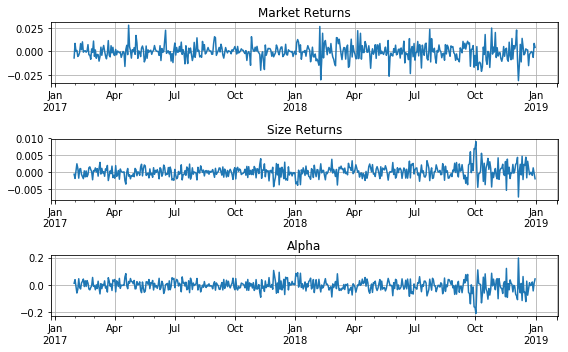

In [63]:
# plot the returns
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
Rm.plot(legend=False, ax=ax1, title='Market Returns', grid=True)
Rs.plot(legend=False, ax=ax2, title='Size Returns', grid=True)
a.plot(legend=False, ax=ax3, title='Alpha', grid=True)

fig.set_size_inches(8,5)
fig.tight_layout()

The figure above shows the daily values of the estimated parameters, while the table below shows some statistics about the parameters. As shown in the table, the magnitude of $\alpha$ is the biggest on average, which is not surprising as it reflects the average upward trend of the market. The market factor and the size factors play an important role as well. Although it is tempting to say that market factor is larger than the size factor in terms of magnitude and hence explains the returns better, it is important to notice also that the average exposure to the market factor is about 1, while the exposure to size is about 20.

Finally, most of the parameters are zero-mean random variables, with $R_m$ exhibiting the largest mean normalized standard deviation, which reflects the chaotic nature of the market.

In [64]:
ParamsStats = pd.DataFrame(index=['Rm','Rs','a','|Rm|','|Rs|','|a|'], columns=['mean', 'stddev', '|stddev/mean|'])

ParamsStats.loc['Rm'] =[Rm.mean(), Rm.std(), abs(Rm.std()/Rm.mean())]
ParamsStats.loc['Rs'] =[Rs.mean(), Rs.std(), abs(Rs.std()/Rs.mean())]
ParamsStats.loc['a'] =[a.mean(), a.std(), abs(a.std()/a.mean())]
ParamsStats.loc['|Rm|'] =[Rm.abs().mean(), Rm.abs().std(), abs(Rm.abs().std()/Rm.abs().mean())]
ParamsStats.loc['|Rs|'] =[Rs.abs().mean(), Rs.abs().std(), abs(Rs.abs().std()/Rs.abs().mean())]
ParamsStats.loc['|a|'] =[a.abs().mean(), a.abs().std(), abs(a.abs().std()/a.abs().mean())]

ParamsStats

mean      stddev |stddev/mean|
Rm   -0.000285951  0.00791252       27.6709
Rs    0.000192386  0.00173227       9.00413
a     -0.00421565   0.0411911         9.771
|Rm|   0.00572882  0.00545938      0.952967
|Rs|   0.00129531  0.00116475      0.899203
|a|     0.0307899   0.0276514      0.898066

#### 2.4.5.c. Specific Returns Analysis

Factors based return decomposition is done on a spatial level (across stocks), while this section looks at the temporal characteristics. Specifically, the correlation over time between the company returns and specific returns $\epsilon_{i}$ are calculated, which are plotted in the histogram below. Since $\epsilon_{i}$ is defined as the difference between the real returns and the returns explainable by the factors, the high magnitude of the these correlations (averaging about 81%) shows that the 2 factors are not sufficient for explaining the given returns (otherwise the correlation would be 0). The correlation is also shown in the scatter plot as the points are centered around the $y=x$ black line.

Text(18.75,0.5,'Returns')

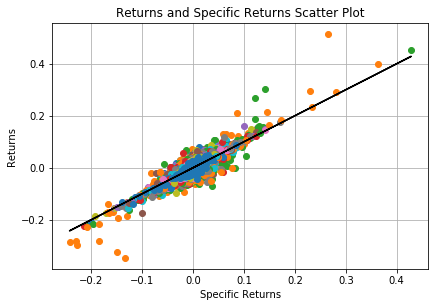

In [65]:
# Scatter plot
for company in e.columns:
    plt.plot(e[company], ri[company], 'o')
plt.plot(e.values.reshape(-1),e.values.reshape(-1), color='black')

plt.grid()
plt.tight_layout()
plt.title('Returns and Specific Returns Scatter Plot')
plt.xlabel('Specific Returns')
plt.ylabel('Returns')

Mean:  0.8114918953521855 0.07592528090185137


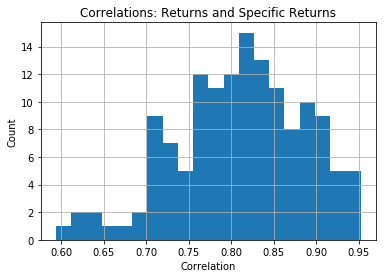

In [66]:
# specific returns 
sr_corr = pd.Series(index=e.columns)
for company in e.columns:
    sr_corr[company]=pearsonr(e[company], ri[company])[0]
sr_corr.hist(bins=20)
plt.title('Correlations: Returns and Specific Returns')
plt.xlabel('Correlation')
plt.ylabel('Count')
print('Mean: ', sr_corr.mean(), sr_corr.std())

#### 2.4.5.d. Factor Returns Analysis

This section explores the magnitude and the stability of covariance matrices $cov(\textbf{R}) \in \mathbb{R}^{2 \text{x} 2} $ estimated using a rolling window of 22 days on the factor return matrix $\textbf{R}$, which is defined as follows:
\begin{equation}
    \textbf{R}=
    \begin{vmatrix}
        Rm_1 & Rs_1\\
        Rm_2 & Rs_2\\
        ...  & ... \\
        Rm_{500} & Rs_{500}\\
    \end{vmatrix}
\end{equation}

The magnitude of the rolling covariance matrices $cov(\textbf{R})$ is plotted in the figure below with color blue, and it is clearly a highly fluctuating signal, which suggests instability. In addition, the average percentage change between each of the 4 elements in the covariance matrix is calculated for successive time steps, which is plotted in the figure in red. The covariance values can change drastically from one day to another, which also highlights the instable nature of the covariance matrix. This demonstrates that past estimations of covariances tend to be obsolete for future uses.

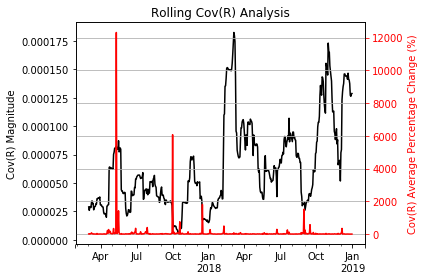

In [67]:
# Create a factor returns dataframe 
# Note R should be 500 in index length (due to :t indexing error from before) 
R = pd.DataFrame(columns=['Rm', 'Rs'])
R['Rm']=Rm
R['Rs']=Rs

# Run a rolling covariance analysis
R_covs = []
w = 22
for t in R.index[w-1:]:
    R_tmp = R[:t].iloc[-w:]
    R_cov = np.cov(R_tmp.T)
    R_covs.append(R_cov)

R_covs=np.array(R_covs)

rolling_magnitude = pd.Series(index=R.index[w-1:])
rolling_stability = pd.Series(index=R.index[w-1:])

for i in range(1, R_covs.shape[0]):
    # Estimate the magnitude
    R_cov = R_covs[i]
    rolling_magnitude[i]=(np.linalg.norm(R_cov))
    
    # Estimate the Stability (absolute percentage change of succesive covariance value)
    R_cov_previous = R_covs[i-1]
    rolling_stability[i]=(100*np.mean(abs((R_cov - R_cov_previous)/(R_cov_previous))))

fig, ax = plt.subplots()
rolling_magnitude.plot(style='black',ax=ax)
plt.tick_params(axis='y', colors='black')
plt.ylabel('Cov(R) Magnitude', color='black')

rolling_stability.plot(style='r-',ax=ax.twinx())
plt.tick_params(axis='y', colors='r')
plt.ylabel('Cov(R) Average Percentage Change (%)', color='r')

plt.title('Rolling Cov(R) Analysis')
plt.grid()
plt.tight_layout()

#### 2.4.5.e. PCA of Specific Returns

This section explores the application of PCA on the covariance matrix of the specific return matrix $\textbf{E}$. Specifically, from the 2 factors model mentioned in the previous section, the specific return is computed as the difference between the actual and estimated company returns for every companies every day, which are collected in the following Matrix:

\begin{equation}
    \textbf{E}=
    \begin{vmatrix}
        \epsilon_{i=1, t=1} & ... & \epsilon_{i=N, t=1}\\
        \epsilon_{i=1, t=2} & ... & \epsilon_{i=N, t=2}\\
        ...  & ... & ... \\
        \epsilon_{i=1, t=T} & ... & \epsilon_{i=N, t=T}\\
    \end{vmatrix}
\end{equation}

The PCA is a dimensionality reduction technique which captures the direction of highest variation in data by projecting the data into a feature space, which offers a quantitative method for identifying factors that explain the variances in the returns. This is done by carrying out the eigenvalue analysis on the covariance matrix, where the eigenvectors represent the directions of most variation (as a linear combination of given features), while the eigenvalues represent how much variation there is for its corresponding eigenvector. 

The figure below shows the eigenvalues arranged in descending order. As it is clear from the figure, the first components contains most of the information as the explained variances decrease rapidly. The first component in particular explains about 7.37% of the total variances. 

% Explained by the 1st Principal Component: 7.37 %


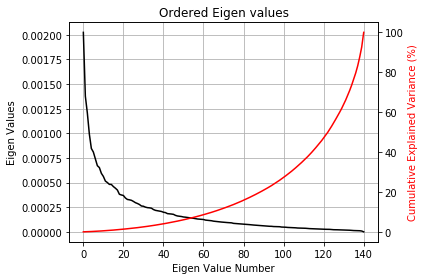

In [68]:
eigvals, eigvecs = np.linalg.eigh(e.astype(float).cov())

# Plot the eigen values
fig, ax = plt.subplots()

ax.plot(eigvals[::-1], color='black')
ax.set_title('Ordered Eigen values')
ax.set_ylabel('Eigen Values')
ax.set_xlabel('Eigen Value Number')
ax.grid()

cum_exp_var = np.cumsum(eigvals/sum(eigvals)*100)
ax.twinx().plot(cum_exp_var, color='r')
plt.ylabel('Cumulative Explained Variance (%)', color='r')

fig.tight_layout()

print('% Explained by the 1st Principal Component:', round(100*eigvals[-1]/sum(eigvals),2), '%')

The market return is often the primary driver of stock returns, which is why the first principal component is usually losely equal to the market return when applying the PCA analysis on the return matrix instead. In the following graph, the blue line is the cumulative return of the portfolio which uses the first principal component as weights (the principal component is scaled to have a sum of 1), while the red line is the market retun computed previously.

Text(0.5,1,'PCA Return Reconstruction')

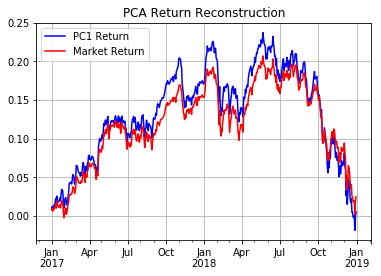

In [69]:
eigvals, eigvecs = np.linalg.eigh(rs.astype(float).cov())

pcw = eigvecs[:,-1]
pcw = pcw/sum(pcw)

rs.dot(pcw).cumsum().plot(style='b-')
rm_nw.cumsum().plot(style='r-')
plt.legend(['PC1 Return','Market Return'])
plt.grid()
plt.title('PCA Return Reconstruction')

However, since the market factor and the size factor are already taken into account in the above APT model, the first principal component is not the market return, as it is shown in the figure below where the returns are weigthed by the non-normalized first principal component, which can indicate some other factors relating to the momentum premium or the value vs growth premium.

Text(0.5,1,'PCA Return Reconstruction')

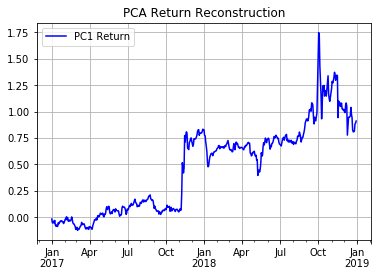

In [70]:
eigvals, eigvecs = np.linalg.eigh(e.astype(float).cov())

pcw = eigvecs[:,-1]
pcw = pcw

rs.dot(pcw).cumsum().plot(style='b-')
plt.legend(['PC1 Return','Market Return'])
plt.grid()
plt.title('PCA Return Reconstruction')

# 3. Portfolio Optimization

## 3.1. Adaptive Minimum-Variance Portfolio Optimization

### 3.1.1. Lagrangian Formulation

This section will explore the minimum variance portfolio optimization problem. Specifically, given a set of weights $\textbf{w}$ in a vector form, the return and the variance of the portfolio at a given time are:
\begin{equation}
    r_p = \textbf{w}^T\textbf{r}
\end{equation}
\begin{equation}
    \sigma_p^2 = \textbf{w}^T\textbf{C}\textbf{w}
\end{equation}
where $\textbf{r}$ is a vector containing the returns of the assets and $\textbf{C}$ is the covariance matrix which each $(i,j)$ element represents the covariance between $i^{th}$ and $j^{th}$ assets $\sigma_{i,j}=\sigma_{i}\sigma_{j}\rho$.

The minimum-variance portfolio can therefore be formulated as the following constrained optimization problem:
\begin{equation}
    \textbf{w}_{opt} = argmin_{\textbf{w}} \frac{1}{2} \textbf{w}^T\textbf{C}\textbf{w} \text{ s.t. } \textbf{w}^T \textbf{1} = 1
\end{equation}

The optimization has the following Lagrangian:
\begin{equation}
    L = \frac{1}{2} \textbf{w}^T\textbf{C}\textbf{w} - \lambda (\textbf{w}^T \textbf{1} - 1)
\end{equation}
    
By differentiating w.r.t. $\textbf{w}$ and $\lambda$ and assuming that $\textbf{C}$ is invertible, the following optimality conditions are obtained:
\begin{equation}
    \frac{dL}{d\textbf{w}} = \textbf{C}\textbf{w} - \lambda \textbf{1} = 0 
    \text{ -> } 
    \textbf{w} = \lambda \textbf{C}^{-1} \textbf{1}
\end{equation}
\begin{equation}
    \frac{dL}{d\lambda} = \textbf{w}^T \textbf{1} - 1 = 0 \text{ -> } \textbf{w}^T \textbf{1} = 1
\end{equation}

The set of optimal weights $\textbf{w}_{opt}$ can be found by solving for $\lambda$ and substituting:
\begin{equation}
    1 = \textbf{w}^T \textbf{1} = (\lambda \textbf{C}^{-1} \textbf{1})^T \textbf{1} 
    = \lambda \textbf{1}^T \textbf{C}^{-1^T} \textbf{1}
    \text{ -> } 
    \lambda = \frac{1}{\textbf{1}^T \textbf{C}^{-1^T} \textbf{1}}
\end{equation}
\begin{equation}
    \textbf{w}_{opt} = \lambda \textbf{C}^{-1} \textbf{1} 
    = \frac{1}{\textbf{1}^T \textbf{C}^{-1^T} \textbf{1}} \textbf{C}^{-1} \textbf{1}
\end{equation}
    
The variance of the optimal portfolio is therefore:
\begin{equation}
    \sigma_p^2 = \textbf{w}_{opt}^T\textbf{C}\textbf{w}_{opt} 
    = \frac{1}{(\textbf{1}^T \textbf{C}^{-1^T} \textbf{1})^2} 
    (\textbf{C}^{-1} \textbf{1})^T \textbf{C} (\textbf{C}^{-1} \textbf{1})
    = \frac{1}{(\textbf{1}^T \textbf{C}^{-1^T} \textbf{1})^2} 
    \textbf{1}^T \textbf{C}^{-1^T} \textbf{1}
    = \frac{1}{\textbf{1}^T \textbf{C}^{-1^T} \textbf{1}}
\end{equation}

Note that the above optimization problems doesn't put a constraint on the inidividual weights $w_i$ which can be positive or negative. The negative number means that shorting is allowed, which means that it is possible to borrow a stock and sell it, which effectively increases the cash value of the portfolio which can be used to buy additional stocks.  

### 3.1.2. Static Minimum-Variance Portfolio

This section will compute the minimum-variance portfolio using the returns of 10 stocks from 2017 to 2018, and test its performance by applying those optimal weights on the same stocks from 2018 to 2019. The figures below plot the results of this portfolio, showing the variance and the cumulative return. This is also compared to the equal weights portfolio where $w_i = \frac{1}{10}$ for $i = 1,2,...,10$.

In [71]:
# Import relevant libraries
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from scipy.optimize import minimize

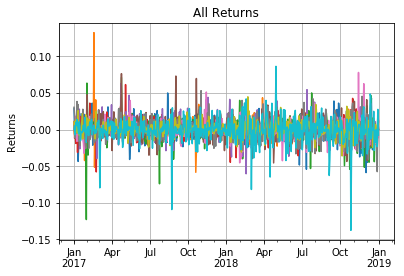

In [72]:
# Read data
df = pd.read_csv('DataSource/fsp_case_31_BSD.csv', index_col=0,header=[0 ,1]) # read the csv file
rs = df['ret'].copy().dropna(1) # all companies returns dropped
rs.index = pd.to_datetime(rs.index) # Seth the index to date time type
rs = rs.iloc[:,-10:] # select only the last 10

rs.plot(title='All Returns', grid=True, legend=False)
plt.ylabel('Returns')

# Split into training and testing sets
rs_tr = rs.iloc[:int(rs.shape[0]/2), :]
rs_te = rs.iloc[int(rs.shape[0]/2):, :]

#### 3.1.2.a Equal Weights Portfolio

The figure below shows the returns and the cumulative returns of the equal-weights portfolio for the period 2018-2019. The performance of this portfolio is summarized in the table below. The performance of this portfolio is undesirable both in terms of returns and volatility.

Mean Return         -0.000473
Cumulative Return   -0.123503
Variance             0.000079
Sharpe              -5.964545
dtype: float64

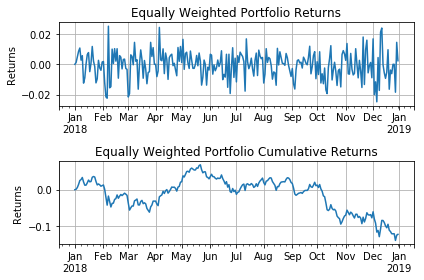

In [73]:
# Equally weighted portfolio
EW_Portfolio = rs_te.mean(1)

fig, (ax1, ax2) = plt.subplots(2,1)
EW_Portfolio.plot(grid=True, title='Equally Weighted Portfolio Returns', ax=ax1).set_ylabel('Returns')
EW_Portfolio.cumsum().plot(grid=True, title='Equally Weighted Portfolio Cumulative Returns', ax=ax2).set_ylabel('Returns')
plt.tight_layout()

EW_Performance = pd.Series()
EW_Performance['Mean Return']=EW_Portfolio.mean()
EW_Performance['Cumulative Return']=EW_Portfolio.cumsum()[-1]
EW_Performance['Variance']=EW_Portfolio.std()**2
EW_Performance['Sharpe']=EW_Portfolio.mean()/EW_Portfolio.std()**2

EW_Performance

#### 3.1.2.b Static Minimum-Variance Portfolio

The figure below shows the minimum variance portfolio using weights computed for the period 2017 to 2018. These weights are first applied to the training period, which shows very small variance as expected which is shown in the table below. Overall, the return is high for this portfolio, which suggests a premium associated with low volatility stocks. Finally, the theoretical variance of the portfolio matches the real one exactly, which is not surprising since the optimal weights are applied to the training data. 

In [74]:
# # Objective function to minimize using the minimizer from scipy
# def portfolio_variance (w, cov):   
#     var = 100*float(w.T.dot(cov).dot(w)) # note the variance is multiplied for computational reasons
#     return var

# # Set up the variables
# w = np.ones((rs_tr.shape[1],1))/rs_tr.shape[1] # initialize weights
# cov = rs_tr.cov() # initialize covariance matrix (training set)

# # Constraints of the optimization
# cons = ({'type': 'eq', 'fun': lambda w: np.sum(w)-1})

# # Minimize
# w_opt = minimize(portfolio_variance, w, args=(cov), constraints=cons).x

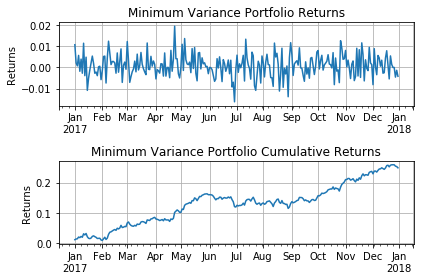

In [75]:
# Compute optimal portfolio
ones = np.ones((rs_tr.shape[1],1))
C = rs_tr.cov()
Lambda = 1/(ones.T.dot(np.linalg.inv(C).T).dot(ones))
w_opt = Lambda*(np.linalg.inv(C).dot(ones))
w_opt = w_opt.reshape(-1,)

# Train Minimum Variance Portfolio
MVTr_Portfolio = (rs_tr*w_opt).sum(1)

fig, (ax1, ax2) = plt.subplots(2,1)
MVTr_Portfolio.cumsum().plot(grid=True, title='Minimum Variance Portfolio Cumulative Returns', ax=ax2).set_ylabel('Returns')
MVTr_Portfolio.plot(grid=True, title='Minimum Variance Portfolio Returns', ax=ax1).set_ylabel('Returns')
plt.tight_layout()

In [76]:
ones = np.ones((w_opt.shape)).reshape(-1,1)
theoretical_var = 1/(ones.T.dot(np.linalg.inv(C).T).dot(ones))

MVTr_Performance = pd.Series()
MVTr_Performance['Mean Return']=MVTr_Portfolio.mean()
MVTr_Performance['Cumulative Return']=MVTr_Portfolio.cumsum()[-1]
MVTr_Performance['Variance']=MVTr_Portfolio.std()**2
MVTr_Performance['Theoretical Variance']=float(theoretical_var)
MVTr_Performance['Sharpe']=MVTr_Portfolio.mean()/MVTr_Portfolio.std()**2

MVTr_Performance

Mean Return              0.000958
Cumulative Return        0.249062
Variance                 0.000029
Theoretical Variance     0.000029
Sharpe                  33.475039
dtype: float64

However, it is not realistic to apply the weights to the period in which the optimal weights are computed from, for the simple reason that this would require future data to be included in the calculation. 

The figure below shows the performance of a portfolio which uses the same weights from before applied to the following year from 2018 to 2019. As shown in the table below, the performance is worse compared to both the equal weights portfolio and the optimal weights portfolio in the training period. The worsening performance in terms of volatility suggests that the variance might have some mean-reversion characteristics.

Mean Return         -0.000451
Cumulative Return   -0.117582
Variance             0.000082
Sharpe              -5.499329
dtype: float64

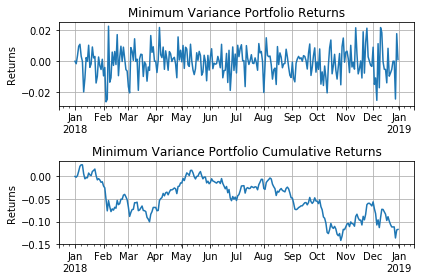

In [77]:
# Test Minimum Variance Portfolio
MV_Portfolio = (rs_te*w_opt).sum(1)

fig, (ax1, ax2) = plt.subplots(2,1)
MV_Portfolio.cumsum().plot(grid=True, title='Minimum Variance Portfolio Cumulative Returns', ax=ax2).set_ylabel('Returns')
MV_Portfolio.plot(grid=True, title='Minimum Variance Portfolio Returns', ax=ax1).set_ylabel('Returns')
plt.tight_layout()

MV_Performance = pd.Series()
MV_Performance['Mean Return']=MV_Portfolio.mean()
MV_Performance['Cumulative Return']=MV_Portfolio.cumsum()[-1]
MV_Performance['Variance']=MV_Portfolio.std()**2
MV_Performance['Sharpe']=MV_Portfolio.mean()/MV_Portfolio.std()**2

MV_Performance

### 3.1.3. Adaptive Minimum-Variance Portfolio

This section uses the minimum-variance optimization method as discussed in previous sections in a recursive manner, updating the weights day by day using a rolling window of length M. The figure and the table below shows the performance of the adaptive minimum-variance portfolio for 252 days (roughly 1 trading year) as well as the changing weights for each of the stocks. 

Overall, the adaptive portfolio shows satisfactory performance in terms of variance, which is lower than both the static minimum-variance portfolio and the equal weights one. However, the cumulative return of the portfolio is not ideal, although this is expected since the optimization did not include any return forecasting. 

In [78]:
# # Objective function to minimize using the minimizer from scipy
# def portfolio_variance (w, cov):   
#     var = 100*float(w.T.dot(cov).dot(w)) # note the variance is multiplied for computational reasons
#     return var

# # Function that computes the optimal weights to minimize the variance
# def compute_w_opt (cov):
    
#     # initialize weights
#     w = np.ones((rs_te.shape[1],1))/rs_te.shape[1]

#     # Constraints of the optimization
#     cons = ({'type': 'eq', 'fun': lambda w: np.sum(w)-1})

#     # Minimize
#     w_opt = minimize(portfolio_variance, w, args=(cov), constraints=cons).x
    
#     return w_opt

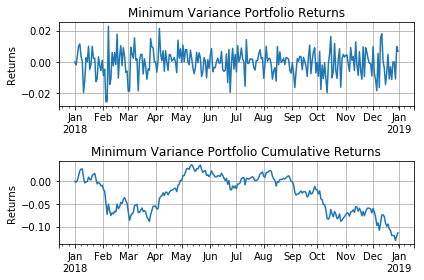

In [79]:
# Compute optimal portfolio
def compute_w_opt (C):
    
    ones = np.ones((rs_tr.shape[1],1))
    Lambda = 1/(ones.T.dot(np.linalg.inv(C).T).dot(ones))
    w_opt = Lambda*(np.linalg.inv(C).dot(ones))
    w_opt = w_opt.reshape(-1,)
    
    return w_opt

AMV_Portfolio = pd.Series() # Initialize the adaptive MV portfolio
w_opts = [] # get all w_opt estimates
w = 252 # window of 1 year

for t in rs_te.index: # step through time
    
    rs_tmp = rs[:t].iloc[-w-1:-1] # take the past 22 returns without today
    cov_tmp = rs_tmp.cov() # compute the covariance matrix
    w_opt = compute_w_opt(cov_tmp) # get the optimal portfolio weights
    w_opts.append(w_opt) # store for historical anlaysis
    
    AMV_Portfolio[t] = sum(rs_te.loc[t]*w_opt) # store the portfolio performance
    

fig, (ax1, ax2) = plt.subplots(2,1)
AMV_Portfolio.cumsum().plot(grid=True, title='Minimum Variance Portfolio Cumulative Returns', ax=ax2).set_ylabel('Returns')
AMV_Portfolio.plot(grid=True, title='Minimum Variance Portfolio Returns', ax=ax1).set_ylabel('Returns')
plt.tight_layout()

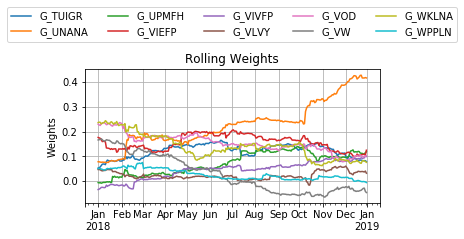

In [80]:
w_opts = np.array(w_opts)
w_opts = pd.DataFrame(data=w_opts, columns=rs_te.columns, index=rs_te.index)
w_opts.plot(grid=True, title='Rolling Weights')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), fancybox=True, ncol=5)
plt.ylabel('Weights')
plt.tight_layout()

In [81]:
AMV_Performance = pd.Series()
AMV_Performance['Mean Return']=AMV_Portfolio.mean()
AMV_Performance['Cumulative Return']=AMV_Portfolio.cumsum()[-1]
AMV_Performance['Variance']=AMV_Portfolio.std()**2
AMV_Performance['Sharpe']=AMV_Portfolio.mean()/AMV_Portfolio.std()**2

AMV_Performance

Mean Return         -0.000436
Cumulative Return   -0.113804
Variance             0.000066
Sharpe              -6.572814
dtype: float64

Finally, the performance of this adaptive portfolio is highly dependent on the estimation window. The figure below shows the cumulative return and the variance of the portfolio using different rolling windows, from 1 month to 12 months.

Mean variance:  7.282110386322032e-05
Median variance:  6.941701421174547e-05


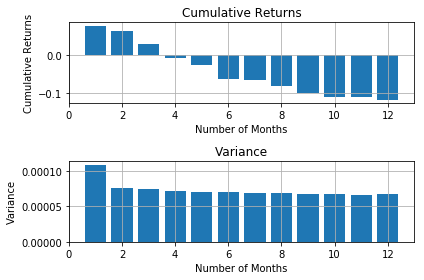

In [82]:
Ms = [22*i for i in range(1,13)]
crs = []
vs = []

for w in Ms:
    
    #print(w)
    
    AMV_Portfolio = pd.Series() # Initialize the adaptive MV portfolio
    w_opts = [] # get all w_opt estimates

    for t in rs_te.index: # step through time

        rs_tmp = rs[:t].iloc[-w-1:-1] # take the past 22 returns without today
        cov_tmp = rs_tmp.cov() # compute the covariance matrix
        w_opt = compute_w_opt(cov_tmp) # get the optimal portfolio weights
        w_opts.append(w_opt) # store for historical anlaysis

        AMV_Portfolio[t] = sum(rs_te.loc[t]*w_opt) # store the portfolio performance

    crs.append(AMV_Portfolio.cumsum()[-1])
    vs.append(AMV_Portfolio.std()**2)
    

n_months = [i for i in range(1,13)]

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.bar(n_months, crs)
ax1.set_title('Cumulative Returns')
ax1.set_xlabel('Number of Months')
ax1.set_ylabel('Cumulative Returns')
ax1.grid()

ax2.bar(n_months, vs)
ax2.set_title('Variance')
ax2.set_xlabel('Number of Months')
ax2.set_ylabel('Variance')
ax2.grid()

fig.tight_layout()

print('Mean variance: ', np.mean(vs))
print('Median variance: ', np.median(vs))

Overall, the adaptive portfolio performs better than both the static minimum variance portfolio and the equal weights portfoio in terms of minimizing the variance, obtaining an average and median variance of 0.000073 and 0.000069 for estimation windows of 1 to 12 months. Not surprisingly, the performance in terms of returns isn't great for the adaptive portfolio, which produced negative results most of the time. This however is to be expected as the optimization didn't take into account the forecasted returns but only variance. In addition, repeatedly changing the weights of the portfolio incurrs high transaction costs that worsens the returns further in a practical scenario. 

Finally, the covariance matrix is estimated by using the returns of the past M day in this example, but there are other methods of estimating it. For instance, it is possible to change the weights for each day in an exponentially weighted manner such that the recent days have a stronger influence on the estimation of the covariance than the older days, although this method introduces additional tunable parameters (exponential weight decay). 

# 4. Robust Statistics and Non-Linear Methods

## 4.1. Data Import and Exploratory Data Analysis

### 4.1.1. Descriptive Statistics

In [83]:
# Import relevant libraries
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import pearsonr, iqr
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from statsmodels.robust.scale import mad as mad_c
import time 

# define the median absolute deviation with no scaling factor 
def mad (ts):
    return mad_c(ts, c=1)

In [84]:
# Read data
AAPL = pd.read_csv('DataSource/AAPL.csv', index_col=0) # read the csv file
AAPL.index = pd.to_datetime(AAPL.index)

IBM = pd.read_csv('DataSource/IBM.csv', index_col=0) # read the csv file
IBM.index = pd.to_datetime(IBM.index)

JPM = pd.read_csv('DataSource/JPM.csv', index_col=0) # read the csv file
JPM.index = pd.to_datetime(JPM.index)

DJI = pd.read_csv('DataSource/DJI.csv', index_col=0) # read the csv file
DJI.index = pd.to_datetime(DJI.index)

all_data = {'AAPL':AAPL, 'IBM':IBM, 'JPM':JPM, 'DJI':DJI} # Put all data together

In [85]:
# Initialize the necessary variables
tickers = ['AAPL','IBM','JPM','DJI'] # Generate descriptive statistics
datatypes = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'] # these are the data types
statistics = ['Mean', 'Median', 'StdDev', 'MAD', 'IQR', 'Skew', 'Kurtosis'] # Statistics to generate
stats_df = pd.DataFrame(index=statistics, columns=datatypes) # create descriptive statistics dataframe
all_stats = {'AAPL':stats_df.copy(), 'IBM':stats_df.copy(), 'JPM':stats_df.copy(), 'DJI':stats_df.copy()} # all stats together

In [86]:
# Step through all the data
for ticker in tickers:
    data = all_data[ticker].copy()
    for datatype in datatypes:
        col = data[datatype]
        
        # Compute all the statistics
        all_stats[ticker][datatype]['Mean'] = col.mean()
        all_stats[ticker][datatype]['Median'] = col.median()
        all_stats[ticker][datatype]['StdDev'] = col.std()
        all_stats[ticker][datatype]['MAD'] = mad(col)
        all_stats[ticker][datatype]['IQR'] = iqr(col)
        all_stats[ticker][datatype]['Skew'] = col.skew()
        all_stats[ticker][datatype]['Kurtosis'] = col.kurtosis()

This section will explore the use of different descriptive statistics on 3 stocks (AAPL, IBM, JPM) and 1 index (DJI). Descriptive statistics are summary statistics that are quantitative measures that summarize a collection of data. In particular, the descriptive statistics explored in this section are mean, median (measures of central tendency), standard deviation, median absolute deviation, interquartile range (measure of dispersion), skew (measure of asymmetry) and kurtosis (measure of distribution tails). Each of the statistics has different characteristics and behave differently in the presence of outliers, which will be explored in detail in the following sections.

Overall, the measures of central tendency (mean and median) tend to be similar for all assets, while the measures of disperson (standard deviation and median absolute deviation) can have very different estiamtes, which could result in drastic performance differences (shown in section 4.4.). 

In [87]:
# Print the value
for ticker in tickers:
    print ()
    print (ticker)
    print (all_stats[ticker])


AAPL
              Open      High       Low     Close Adj Close       Volume
Mean       187.687   189.562   185.824   187.712   186.174  3.27048e+07
Median      186.29     187.4    184.94    186.12   184.352   2.9184e+07
StdDev     22.1456   22.2816   22.0088   22.1607   21.9047  1.41797e+07
MAD          15.89     15.61     15.92     15.94    15.476   7.5739e+06
IQR             36     36.34     36.06    36.755   35.6854  1.63117e+07
Skew      0.259917  0.300385  0.220489  0.263849   0.29077      1.74332
Kurtosis -0.912594 -0.924602 -0.917632 -0.932425 -0.928017      4.35318

IBM
              Open      High       Low     Close Adj Close       Volume
Mean       138.454   139.492   137.329   138.363   134.903  5.19894e+06
Median      142.81    143.99    142.06    142.71   138.566   4.2379e+06
StdDev     12.1143   11.9131   12.2046   12.0281   10.6716  3.32896e+06
MAD           5.27      5.31      5.19   5.23001   4.49352       920700
IQR          15.38     14.72     16.34    15.505   14

In [88]:
# add the adjusted returns to each ticker
for ticker in tickers:
    all_data[ticker]['Returns'] = all_data[ticker]['Adj Close'].pct_change()

### 4.1.2. Histograms and PDF

The figure below shows the empirical probability density function (red) and the histogram of the distributions (blue) of the adjusted closing prices and of 1-day returns for each of the tickers mentioned previously. As discussed in the part 1 of the coursework, the returns tend to follow a more normal distribution than the raw prices, which can be seen in the PDFs below. This means that most of the classical statistics which assumes an underlying Gaussian distribution work better with returns rather than prices. This suggests the use of statistics such as median and median absolute deviation when working with prices instead of mean and standard deviation.

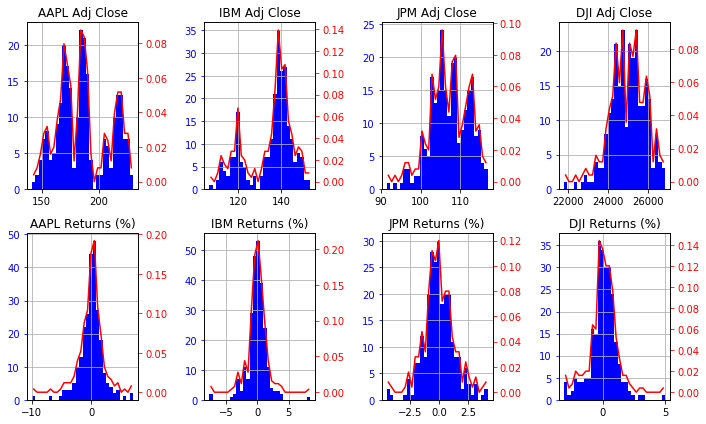

In [89]:
# 4x2 PDFs (tickers x adjclose & returns)
fig, ax = plt.subplots(2,4)   

for i in range(len(tickers)):
    
    # get price data -------------------------------------------- 
    ps_tmp = all_data[tickers[i]]['Adj Close'].dropna()
    
    # plot histogram 
    tmp = ax[0][i].hist(ps_tmp, bins=30, color='b') 
    ax[0][i].tick_params(axis='y', colors='b')
    
    # plot PDF
    tmp_ax = ax[0][i].twinx() 
    tmp_ax.plot(tmp[1][1:]-0.5*(tmp[1][1]-tmp[1][0]), tmp[0]/sum(tmp[0]), color='r')
    tmp_ax.tick_params(axis='y', colors='r')
    
    # format 
    ax[0][i].set_title(tickers[i]+' Adj Close')
    ax[0][i].grid()
    
    # get return data -------------------------------------------- 
    rs_tmp = 100*all_data[tickers[i]]['Returns'].dropna()
    
    # plot histogram
    tmp = ax[1][i].hist(rs_tmp, bins=30, color='b')
    ax[1][i].tick_params(axis='y', colors='b')
    
    # plot PDF
    tmp_ax = ax[1][i].twinx() 
    tmp_ax.plot(tmp[1][1:]-0.5*(tmp[1][1]-tmp[1][0]), tmp[0]/sum(tmp[0]), color='r')
    tmp_ax.tick_params(axis='y', colors='r')
    
    # format
    ax[1][i].set_title(tickers[i]+' Returns (%)')
    ax[1][i].grid()
    
fig.set_size_inches(10,6)
fig.tight_layout()

### 4.1.3. Mean vs Median Estimators

This section uses 2 Z-score based methods for outlier detection. The first one classifies all prices levels outside of the rolling price mean $\pm$1.5x standard deviations as outliers, while the second one uses the rolling price median $\pm$1.5x median absolute deviation. 

As shown in the figures below, the blue area that denotes the Z-score range changes more smoothly for method 1 than method 2. This is because the mean based estimators are affected more by the presence of outliers than median based estimators, which makes the mean based estimators more susceptible to changes. For the same reason, the number of outliers detected in method 1 is much less than method 2 since the measure of deviation is impacted more in method 1, which is shown in the table below. This demonstrates the robustness of median as estimator compared to the mean in the sense that it is less effected by the contaminated data. 

In [90]:
# Create a DataFrame of adj. closes for all the assets
AdjCloses = pd.DataFrame(columns=tickers)
for ticker in tickers:
    AdjCloses[ticker] = all_data[ticker]['Adj Close'].copy()

# Create a table containing the outlier counts of both methods
outliers = pd.DataFrame(columns=['Mean Method', 'Median Method'], index=tickers)

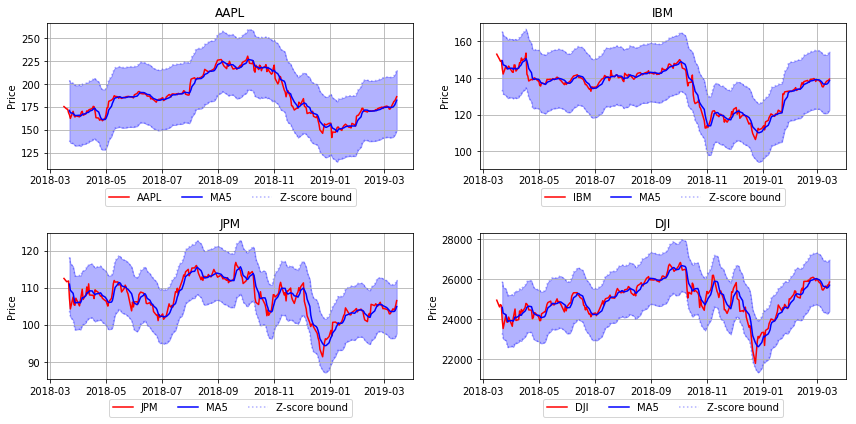

In [91]:
# Rolling mean and stddev
w = 5 # 5 days window
fig, axs = plt.subplots(2,2) # plot 2 by 2

for ticker in tickers:
    
    ts = AdjCloses[ticker].copy()
    ts_rmean = ts.rolling(w).mean()
    ts_u = ts_rmean+1.5*ts.std()
    ts_d = ts_rmean-1.5*ts.std()
    
    if ticker == tickers[0]: 
        ax = axs[0][0]
    if ticker == tickers[1]: 
        ax = axs[0][1]
    if ticker == tickers[2]: 
        ax = axs[1][0]
    if ticker == tickers[3]: 
        ax = axs[1][1]
    
    ax.plot(ts, 'r-')
    ax.plot(ts_rmean, 'b-')
    ax.plot(ts_u, 'b:', alpha=0.3)
    ax.plot(ts_d, 'b:', alpha=0.3)
    ax.fill_between(ts_rmean.index, ts_u, ts_d, color='b', alpha=0.3)
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid()
    ax.legend([ticker, 'MA5', 'Z-score bound'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    outliers.loc[ticker]['Mean Method'] = len(ts[ts>ts_u])+len(ts[ts<ts_d])

fig.set_size_inches(12,6)
fig.tight_layout()

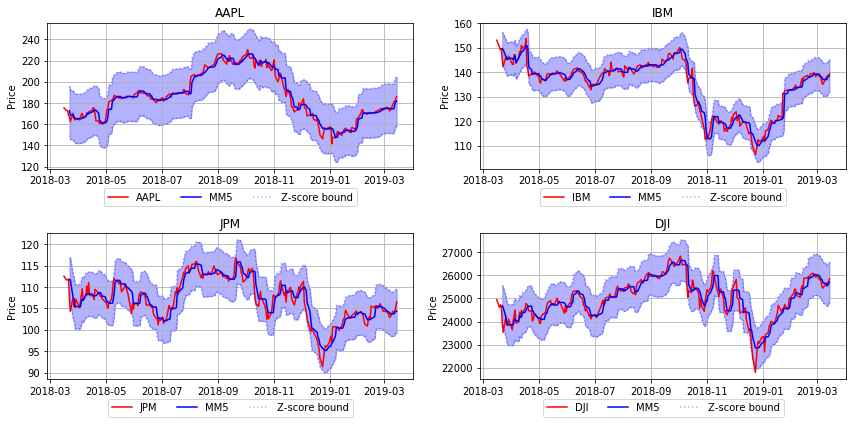

In [92]:
# Rolling median and mad
w = 5 # 5 days window
fig, axs = plt.subplots(2,2) # plot 2 by 2

for ticker in tickers:
    
    ts = AdjCloses[ticker].copy()
    ts_rmedian = ts.rolling(w).median()
    ts_u = ts_rmedian+1.5*mad(ts)
    ts_d = ts_rmedian-1.5*mad(ts)
    
    if ticker == tickers[0]: 
        ax = axs[0][0]
    if ticker == tickers[1]: 
        ax = axs[0][1]
    if ticker == tickers[2]: 
        ax = axs[1][0]
    if ticker == tickers[3]: 
        ax = axs[1][1]
        
    ax.plot(ts, 'r-')
    ax.plot(ts_rmedian, 'b-')
    ax.plot(ts_u, 'b:', alpha=0.3)
    ax.plot(ts_d, 'b:', alpha=0.3)
    ax.fill_between(ts_rmedian.index, ts_u, ts_d, color='b', alpha=0.3)
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid()
    ax.legend([ticker, 'MM5', 'Z-score bound'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    outliers.loc[ticker]['Median Method'] = len(ts[ts>ts_u])+len(ts[ts<ts_d])
    
fig.set_size_inches(12,6)
fig.tight_layout()

In [93]:
print('Outliers Count: ')
outliers

Outliers Count: 


Mean Method Median Method
AAPL           0             0
IBM            0             8
JPM            0             3
DJI            0             3

In reality, it is impossible to use the above method since the computation of standard deviation and median absolute deviation requires the knowledge of the future data. An alternative approach would be to calculate the z-score using the rolling estimation of these values, which is shown in the figure below. Although the computation is on a rolling basis, the same arguments apply and the results are similar. Overall, the rolling method detects more outliers than the static method, which is expected since the price range tends to be bounded within a small area in the short term window.  

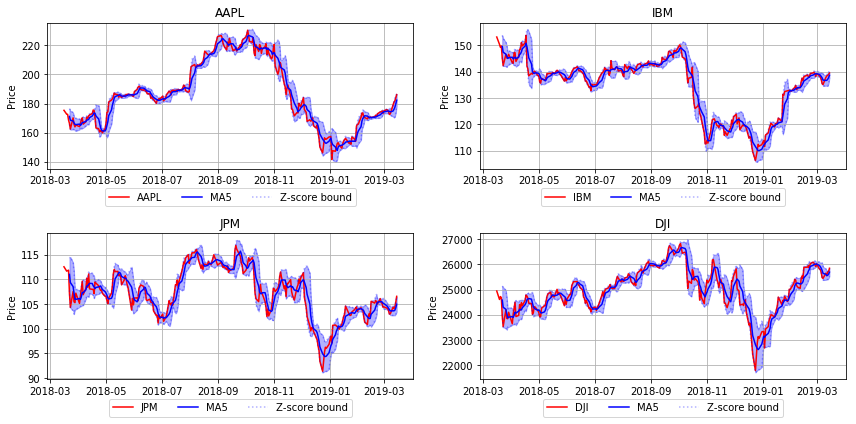

In [94]:
# Rolling mean and stddev
w = 5 # 5 days window
fig, axs = plt.subplots(2,2) # plot 2 by 2

for ticker in tickers:
    
    ts = AdjCloses[ticker].copy()
    ts_rmean = ts.rolling(w).mean()
    ts_rstd = ts.rolling(w).std()
    ts_u = ts_rmean+1.5*ts_rstd
    ts_d = ts_rmean-1.5*ts_rstd
    
    if ticker == tickers[0]: 
        ax = axs[0][0]
    if ticker == tickers[1]: 
        ax = axs[0][1]
    if ticker == tickers[2]: 
        ax = axs[1][0]
    if ticker == tickers[3]: 
        ax = axs[1][1]
    
    ax.plot(ts, 'r-')
    ax.plot(ts_rmean, 'b-')
    ax.plot(ts_u, 'b:', alpha=0.3)
    ax.plot(ts_d, 'b:', alpha=0.3)
    ax.fill_between(ts_rmean.index, ts_u, ts_d, color='b', alpha=0.3)
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid()
    ax.legend([ticker, 'MA5', 'Z-score bound'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    outliers.loc[ticker]['Mean Method'] = len(ts[ts>ts_u])+len(ts[ts<ts_d])

fig.set_size_inches(12,6)
fig.tight_layout()

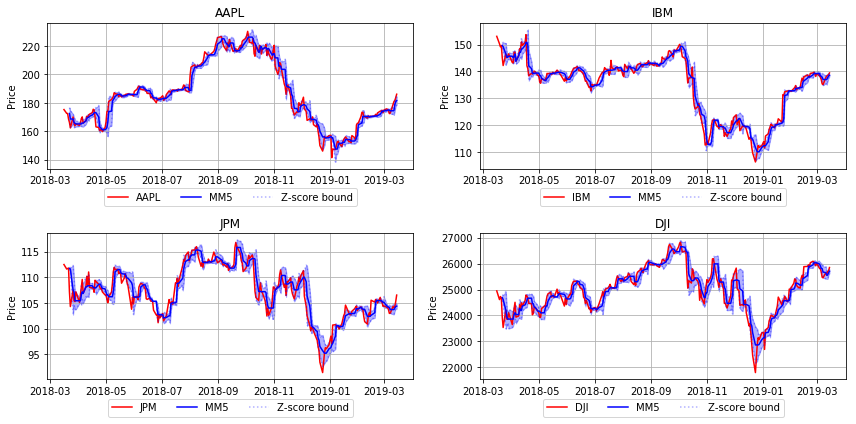

In [95]:
# Rolling median and mad
w = 5 # 5 days window
fig, axs = plt.subplots(2,2) # plot 2 by 2

for ticker in tickers:
    
    ts = AdjCloses[ticker].copy()
    ts_rmedian = ts.rolling(w).median()
    ts_rmad = ts.rolling(w).apply(mad, raw=True)
    ts_u = ts_rmedian+1.5*ts_rmad
    ts_d = ts_rmedian-1.5*ts_rmad
    
    if ticker == tickers[0]: 
        ax = axs[0][0]
    if ticker == tickers[1]: 
        ax = axs[0][1]
    if ticker == tickers[2]: 
        ax = axs[1][0]
    if ticker == tickers[3]: 
        ax = axs[1][1]
        
    ax.plot(ts, 'r-')
    ax.plot(ts_rmedian, 'b-')
    ax.plot(ts_u, 'b:', alpha=0.3)
    ax.plot(ts_d, 'b:', alpha=0.3)
    ax.fill_between(ts_rmedian.index, ts_u, ts_d, color='b', alpha=0.3)
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid()
    ax.legend([ticker, 'MM5', 'Z-score bound'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    outliers.loc[ticker]['Median Method'] = len(ts[ts>ts_u])+len(ts[ts<ts_d])
    
fig.set_size_inches(12,6)
fig.tight_layout()

In [96]:
print('Outliers Count: ')
outliers

Outliers Count: 


Mean Method Median Method
AAPL          30           103
IBM           31            94
JPM           33           105
DJI           30            97

### 4.1.4. Impact of Outliers

For this section, outliers are manufactured and introduced to dates 2018-05-14, 2018-09-14, 2018-12-14 and 2019-01-14. The outliers have the value equivalent to 1.2 times the all time maximum for each of the assets. Due to the same reasons discussed before, it is not surprising to see in the figures below that the both the Z-score range and the mean is highly affected by the presence of outliers in method 1, while the second method didn't change at all. 

In [97]:
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']
# for each ticker
for ticker in tickers:
    max_val = AdjCloses[ticker].max()
    for date in dates:
        AdjCloses[ticker][date]=1.2*max_val

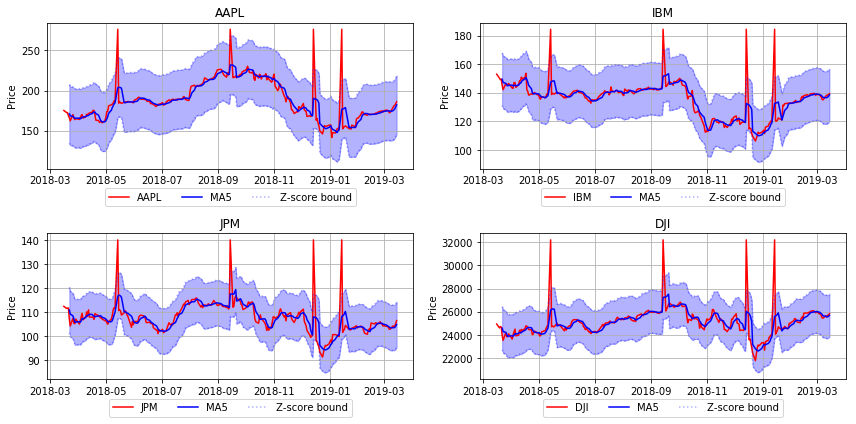

In [98]:
# Rolling mean and stddev
w = 5 # 5 days window
fig, axs = plt.subplots(2,2) # plot 2 by 2

for ticker in tickers:
    
    ts = AdjCloses[ticker].copy()
    ts_rmean = ts.rolling(w).mean()
    ts_u = ts_rmean+1.5*ts.std()
    ts_d = ts_rmean-1.5*ts.std()

    if ticker == tickers[0]: 
        ax = axs[0][0]
    if ticker == tickers[1]: 
        ax = axs[0][1]
    if ticker == tickers[2]: 
        ax = axs[1][0]
    if ticker == tickers[3]: 
        ax = axs[1][1]    
    
    ax.plot(ts, 'r-')
    ax.plot(ts_rmean, 'b-')
    ax.plot(ts_u, 'b:', alpha=0.3)
    ax.plot(ts_d, 'b:', alpha=0.3)
    ax.fill_between(ts_rmean.index, ts_u, ts_d, color='b', alpha=0.3)
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid()
    ax.legend([ticker, 'MA5', 'Z-score bound'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

fig.set_size_inches(12,6)
fig.tight_layout()

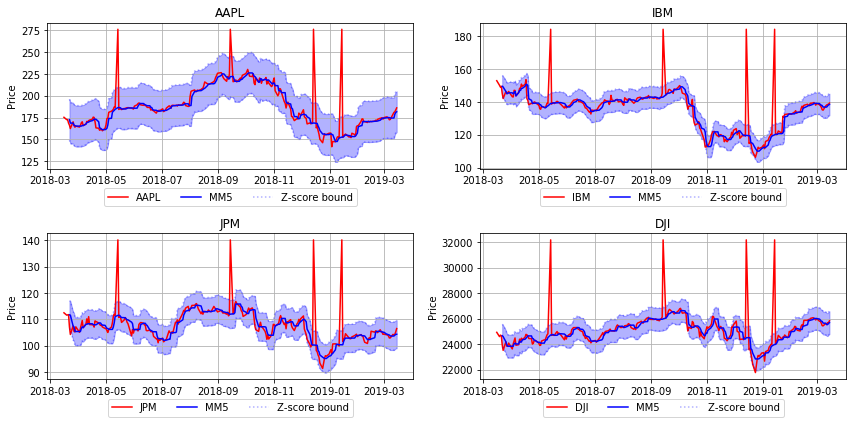

In [99]:
# Rolling median and mad
fig, axs = plt.subplots(2,2) # plot 2 by 2

for ticker in tickers:
    
    ts = AdjCloses[ticker].copy()
    ts_rmedian = ts.rolling(w).median()
    ts_u = ts_rmedian+1.5*mad(ts)
    ts_d = ts_rmedian-1.5*mad(ts)
    
    if ticker == tickers[0]: 
        ax = axs[0][0]
    if ticker == tickers[1]: 
        ax = axs[0][1]
    if ticker == tickers[2]: 
        ax = axs[1][0]
    if ticker == tickers[3]: 
        ax = axs[1][1]   
    
    ax.plot(ts, 'r-')
    ax.plot(ts_rmedian, 'b-')
    ax.plot(ts_u, 'b:', alpha=0.3)
    ax.plot(ts_d, 'b:', alpha=0.3)
    ax.fill_between(ts_rmedian.index, ts_u, ts_d, color='b', alpha=0.3)
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid()
    ax.legend([ticker, 'MM5', 'Z-score bound'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

fig.set_size_inches(12,6)
fig.tight_layout()

The figures below show the same performance but applied to the rolling method, which further confirms the robustness of the median method.

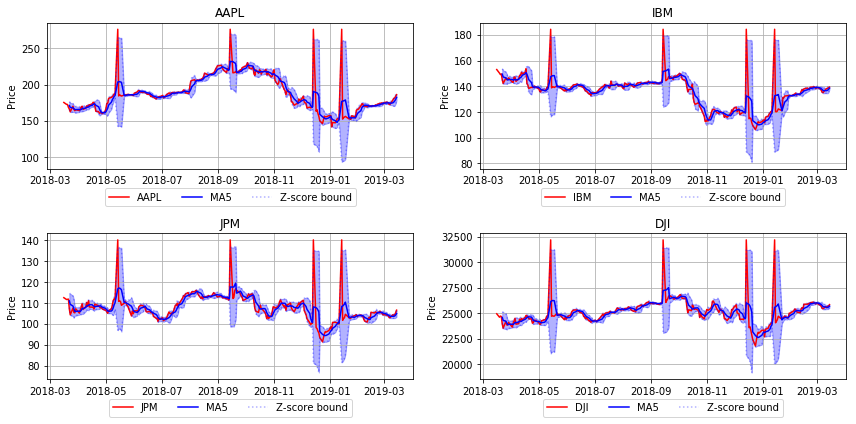

In [100]:
# Rolling mean and stddev
w = 5 # 5 days window
fig, axs = plt.subplots(2,2) # plot 2 by 2

for ticker in tickers:
    
    ts = AdjCloses[ticker].copy()
    ts_rmean = ts.rolling(w).mean()
    ts_rstd = ts.rolling(w).std()
    ts_u = ts_rmean+1.5*ts_rstd
    ts_d = ts_rmean-1.5*ts_rstd

    if ticker == tickers[0]: 
        ax = axs[0][0]
    if ticker == tickers[1]: 
        ax = axs[0][1]
    if ticker == tickers[2]: 
        ax = axs[1][0]
    if ticker == tickers[3]: 
        ax = axs[1][1]    
    
    ax.plot(ts, 'r-')
    ax.plot(ts_rmean, 'b-')
    ax.plot(ts_u, 'b:', alpha=0.3)
    ax.plot(ts_d, 'b:', alpha=0.3)
    ax.fill_between(ts_rmean.index, ts_u, ts_d, color='b', alpha=0.3)
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid()
    ax.legend([ticker, 'MA5', 'Z-score bound'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

fig.set_size_inches(12,6)
fig.tight_layout()

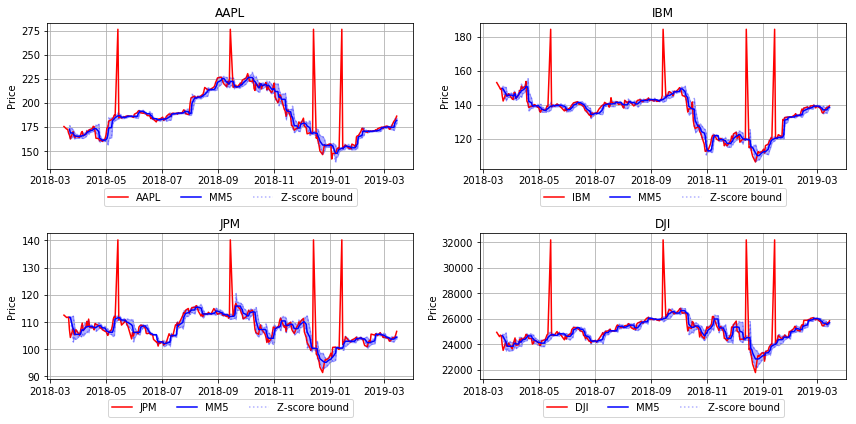

In [101]:
# Rolling median and mad
fig, axs = plt.subplots(2,2) # plot 2 by 2

for ticker in tickers:
    
    ts = AdjCloses[ticker].copy()
    ts_rmedian = ts.rolling(w).median()
    ts_rmad = ts.rolling(w).apply(mad, raw=True)
    ts_u = ts_rmedian+1.5*ts_rmad
    ts_d = ts_rmedian-1.5*ts_rmad
    
    if ticker == tickers[0]: 
        ax = axs[0][0]
    if ticker == tickers[1]: 
        ax = axs[0][1]
    if ticker == tickers[2]: 
        ax = axs[1][0]
    if ticker == tickers[3]: 
        ax = axs[1][1]   
    
    ax.plot(ts, 'r-')
    ax.plot(ts_rmedian, 'b-')
    ax.plot(ts_u, 'b:', alpha=0.3)
    ax.plot(ts_d, 'b:', alpha=0.3)
    ax.fill_between(ts_rmedian.index, ts_u, ts_d, color='b', alpha=0.3)
    ax.set_title(ticker)
    ax.set_ylabel('Price')
    ax.grid()
    ax.legend([ticker, 'MM5', 'Z-score bound'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

fig.set_size_inches(12,6)
fig.tight_layout()

### 4.1.5. Box Plots

Another useful tool for analyzing the data without making parametric assumptions about the distribution is to plot the box plots, which are plotted below for each of the assets. The box plot summarizes the data graphically by analyzing the dispersion of the data, where the orange line denotes the median of the data, the length of the box represents the interquartile range IQR (from Q1 where 25% of the data can be found to Q3 where 75% of the data can be found), and the whiskers extends to the total range of the data. Finally, the outliers are plotted as points, which are defined as points which are outside 1.5x the IQR. 

Overall, for the following box plots, it can be seen that the data tends to be skewed with asymmetric quartiles and has multiple outlier points. This means that the classical gaussian models are unfit to describe the price distributions. 

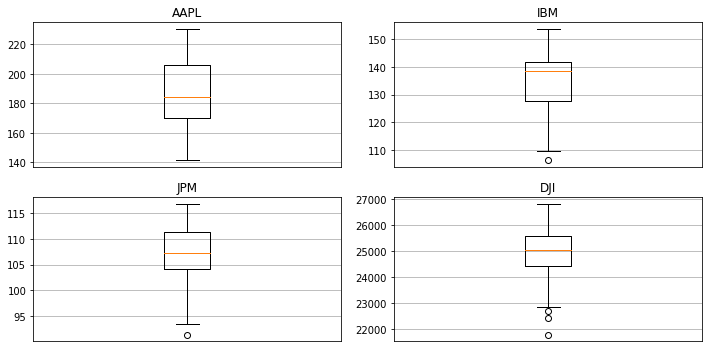

In [102]:
# Create a DataFrame of adj. closes for all the assets
AdjCloses = pd.DataFrame(columns=tickers)
for ticker in tickers:
    AdjCloses[ticker] = all_data[ticker]['Adj Close'].copy()

fig, axs = plt.subplots(2,2) # plot 2 by 2
for ticker in tickers:
    
    if ticker == tickers[0]: 
        ax = axs[0][0]
    if ticker == tickers[1]: 
        ax = axs[0][1]
    if ticker == tickers[2]: 
        ax = axs[1][0]
    if ticker == tickers[3]: 
        ax = axs[1][1]   
        
    ax.boxplot(AdjCloses[ticker])
    ax.set_title(ticker)
    ax.set_xticks([])
    ax.grid()

fig.set_size_inches(10,5)
fig.tight_layout()

## 4.2. Robust Estimators

### 4.2.1 Custom Robust Estimators

This section explores the computational complexity of robust estimators such as median, interquartile range (IQR) and the median absolute deviation (MAD). These robust estimators are non-linear methods since operations such as sorting is needed. The following custom function performs the calculation of the mentioned estimators:

In [103]:
def CustomMedian (ts):
    tmp = ts.sort_values() # sorting 
    median = tmp[round(len(tmp)/2)] # find the middle values
    return median 

def CustomIQR (ts):
    tmp = ts.sort_values() # sorting 
    p25 = tmp[round(len(tmp)/4)] # find the 25th percentile value
    p75 = tmp[round(len(tmp)/4*3)] # find the 75th percentile value
    iqr = p75-p25
    return iqr 

def CustomMAD (ts):
    median = CustomMedian (ts) # compute the median first
    deviations = abs(ts - median) # compute the deviations from the median
    mad = CustomMedian(deviations) # compute the median of deviations
    return mad

In [104]:
print(ts.median(), iqr(ts), mad(ts))
print(CustomMedian(ts),CustomIQR(ts),CustomMAD(ts))

25058.119141 1190.3603514999995 598.861327999999
25063.890625 1194.4003900000025 605.4296880000002


The logic behind each of the functions above are as follows:
    
    1. Median: 
    The given array is sorted in terms of value first, then the middle number is extracted as the median.
    
    2. IQR: 
    The values are sorted, then the 25th and the 75th percentile numbers are found (values below which 25% and 75% of the data can be found respectively). Then, the interquartile range is found as the absolute difference between the two values.
    
    3. MAD:
    For the median absolute deviation, the median is found first. Then, the absolute deviation from the median is computed for all the numbers available. Finally, the MAD is computed as the median of all absolute deviations.

### 4.2.2. Complexity Analysis

To find the median, the array must be sorted first, which has complexity $O(nlog(n))$ using merge sort algorithm where $n$ is the size of the array. Then, the middle value is simply the value with index $int(\frac{n}{2})$, which takes complexity $O(1)$. 

For the IQR, there is first a sorting operation of complexity $O(nlog(n))$, then it finds the values with index $int(\frac{n}{4})$ and $int(3\frac{n}{4})$ respectively and computes their differences, which are 3 operations of complexity $O(1)$. This is hence slightly more expensive than the median estimator. 

Finally, for the MAD, it needs to find the median first which has complexity $O(nlog(n))$. Then, it computes the deviation from the median for all $n$ data which has complexity $O(n)$. Finally, the median of all deviations is found to be the MAD which is anothe operation of complexity $O(nlog(n))$. Overall, MAD is the estimator with the highest computational cost.

The time required for the robust estimators mentioned above is much more than the classic methods such as mean and standard deviation, which have complexity of $O(n)$. 

### 4.2.3. Breakdown Points

The breakdown point of an estimator measures its robustness. It measures a level above which the estimator can arbitrarily deteriorate if the sample data were contaminated. Formally, the finite sample breakdown point is the fraction of the data that can be contaminated without making the estimator bad for a sample of data of size $n$. The breakdown point instead refers usually to the asymptotic breakdown point, which is the finite sample breakdown point as $n$ tends to infinity.

Since the median estimator is the middle value of a sorted array, up to $\frac{(0.5n-1)}{n}$ can have arbitrary values without affecting the estimate, which makes the breakdown point of the median 0.5 as $n$ approaches infinity. Similarly, the IQR estimator has a breakdown point of 0.25 since it splits the data array into 4 parts instead of 2 parts (the case for the median). Finally, the MAD has the same breakdown point as the median of 0.5, since it computes the median and then finds the median of absolute deviation from the median.

## 4.3. Robust and OLS Regression

In [105]:
# Get returns
ri = pd.DataFrame(columns=tickers)
for ticker in tickers:
    ri[ticker] = all_data[ticker]['Returns'].copy().dropna()

### 4.3.1. OLS Regression

This section will compare the ordinary least squares (OLS) regression method against a more robust method such as Huber regression by regressing the returns of each stock against the DJI index. Overall, the regression problem has the following set up: 
\begin{equation}
    \textbf{r} = \textbf{X} \textbf{b} + \textbf{e}
\end{equation}
where $\textbf{r}$ is the returns vector containing the returns of the stock, $\textbf{X}$ is the matrix with a column of ones and a column of DJI returns, and $\textbf{e}$ is the error vector. The OLS method aims to minimize the squared error $||\textbf{e}||^2=||\textbf{r} - \textbf{X} \textbf{b} ||^2$ and has solution $\hat{\textbf{b}} = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T \textbf{r}$.

The figure and the table below show the results of the OLS regression, as well as the given parameters.

AAPL          IBM          JPM          DJI
alpha  0.00016466 -0.000440572 -0.000316331 -8.13152e-20
beta      1.32558     0.960092     0.931408            1

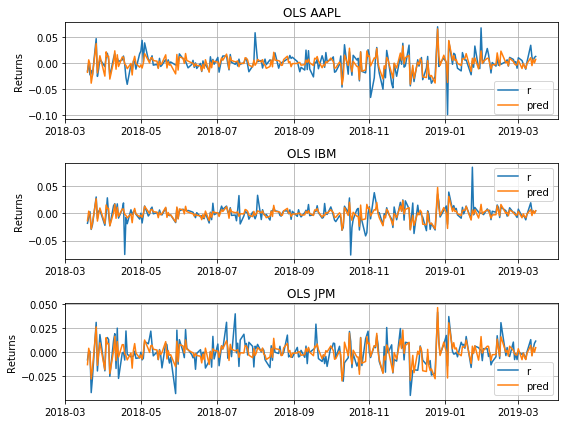

In [106]:
# Ordinary least squares regression
regr = linear_model.LinearRegression()
params = pd.DataFrame(columns=tickers, index=['alpha', 'beta'])
fig, axs = plt.subplots(3,1) 

for ticker in tickers:
    y = ri[ticker].copy().values.reshape(-1,1)
    x = ri['DJI'].copy().values.reshape(-1,1)
    regr.fit(x, y)
    params[ticker]['alpha'] = float(regr.intercept_)
    params[ticker]['beta'] = float(regr.coef_)
    
    if ticker != 'DJI':
        
        if ticker == tickers[0]: 
            ax = axs[0]
        if ticker == tickers[1]: 
            ax = axs[1]
        if ticker == tickers[2]: 
            ax = axs[2]
        
        pred = regr.predict(x)
        ax.plot(ri[ticker].index, y)
        ax.plot(ri[ticker].index, pred)
        ax.legend(['r','pred'])
        ax.grid()
        ax.set_title('OLS '+ticker)
        ax.set_ylabel('Returns')
        
fig.set_size_inches(8,6)
fig.tight_layout()

params

### 4.3.2. Robust Regression (Huber Regression)

The OLS regression method aims to minimize the squared erros which is a measure of squared deviations. Therefore, this regression method is highly sensitive to outliers in the data for reasons similar to why standard deviation is a non-robust estimate. Therefore, the OLS model assumes that there is a constant underlying distribution with constant variance, and its performance degrades under heteroscedasticity or in presence of outliers. 

The Huber regression instead aims to provide a more robust version of OLS method by minimizing the squared error for $\frac{||\textbf{r} - \textbf{X} \textbf{b} ||}{\sigma} < \epsilon$ and the absolute error for $\frac{||\textbf{r} - \textbf{X} \textbf{b} ||}{\sigma} > \epsilon$.  By making the error asymmetric such that it is quadratic for small values but linear for bigger ones, it effectively reduces the impact of outliers on the estimation of the parameters. Therefore, by changing the value of $\epsilon$, it is possible to control the point at which the errors are considered outliers.

The figures and the table below shows the results of this regression and the estiamted parameters respectively. 

AAPL          IBM          JPM          DJI
alpha -0.000130371 -0.000509435 -0.000800961 -2.47219e-11
beta       1.27021     0.973562     0.919662            1

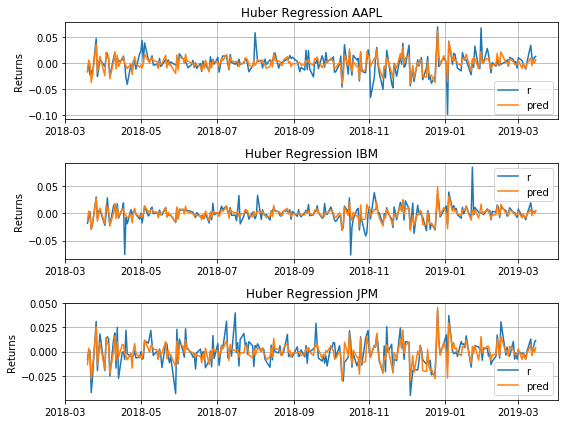

In [107]:
# Huber regression
regr = linear_model.HuberRegressor()
Hparams = pd.DataFrame(columns=tickers, index=['alpha', 'beta'])
fig, axs = plt.subplots(3,1) 

for ticker in tickers:
    y = ri[ticker].values.reshape(-1)
    x = ri['DJI'].values.reshape(-1,1)
    regr.fit(x, y)
    Hparams[ticker]['alpha'] = float(regr.intercept_)
    Hparams[ticker]['beta'] = float(regr.coef_)
    
    if ticker != 'DJI':
        pred = regr.predict(x)
        
        if ticker == tickers[0]: 
            ax = axs[0]
        if ticker == tickers[1]: 
            ax = axs[1]
        if ticker == tickers[2]: 
            ax = axs[2]
            
        ax.plot(ri[ticker].index, y)
        ax.plot(ri[ticker].index, pred)
        ax.legend(['r','pred'])
        ax.grid()
        ax.set_title('Huber Regression '+ticker)
        ax.set_ylabel('Returns')
        
fig.set_size_inches(8,6)
fig.tight_layout()

Hparams

### 4.3.3. Regression and Outliers 

Overall, the two regression methods produced fairly similar estimates of the coefficients as shown in the tables below. It is possible to quantify the impact of outliers by using the same method of section 4.1.4., where artificial outliers with values equivalent to the 1.2x the all time maximum are introduced. As shown in the table below, the new parameters of the OLS method changed by 81% from the previous values while the Huber method only changed by 54%, which empirically demonstrates the robustness of Huber regression.

In [108]:
dates = ['2018-05-14', '2018-09-14', '2018-12-14', '2019-01-14']
# for each ticker
for ticker in tickers:
    max_val = ri[ticker].max()
    for date in dates:
        ri[ticker][date]=1.2*max_val

# Ordinary least squares regression
regr = linear_model.LinearRegression()
Oparams = pd.DataFrame(columns=tickers, index=['alpha', 'beta'])

for ticker in tickers:
    y = ri[ticker].copy().values.reshape(-1,1)
    x = ri['DJI'].copy().values.reshape(-1,1)
    regr.fit(x, y)
    Oparams[ticker]['alpha'] = float(regr.intercept_)
    Oparams[ticker]['beta'] = float(regr.coef_)
    
# Huber regression
regr = linear_model.HuberRegressor()
OHparams = pd.DataFrame(columns=tickers, index=['alpha', 'beta'])

for ticker in tickers:
    y = ri[ticker].values.reshape(-1)
    x = ri['DJI'].values.reshape(-1,1)
    regr.fit(x, y)
    OHparams[ticker]['alpha'] = float(regr.intercept_)
    OHparams[ticker]['beta'] = float(regr.coef_)
  

In [109]:
Oparams

AAPL          IBM          JPM         DJI
alpha  0.000350419 -6.28721e-05 -0.000467133  2.1684e-19
beta       1.35047      1.22204     0.906468           1

In [110]:
OHparams

AAPL         IBM          JPM          DJI
alpha  0.000122268 -0.00033875 -0.000933215  1.72253e-11
beta       1.33077     1.06664     0.890359            1

In [111]:
print('OLS parameters percentage change: ')
print(100*np.mean(abs((Oparams.values.reshape(-1) - params.values.reshape(-1))/params.values.reshape(-1))))
print('Hubber parameters percentage change: ')
print(100*np.mean(abs((OHparams.values.reshape(-1) - Hparams.values.reshape(-1))/Hparams.values.reshape(-1))))

OLS parameters percentage change: 
80.59006350922463
Hubber parameters percentage change: 
53.87407183904137


## 4.4. Robust Trading Strategies

### 4.4.1. Simple Moving Average Cross Over

This section explores the moving average cross-over strategy which decides to buy if the 20-day moving average is above the 50-day moving average and to sell if it is below. The performance of this strategy is plotted in the figues below for each of the assets, where the left figures show the standard performance while the right ones show the same time-series but corrupted with spikes in random directions. Following the discussion of previous sections, it is not surprising to see that the cross-over regions (blue for long and red for short) are affected heavily by the presence of outliers, which led to significant change in perfromance. The amount of overlap in long-short decisions between the 2 cases are listed in the table below.

In [112]:
# Create a DataFrame of adj. closes for all the assets
AdjCloses = pd.DataFrame(columns=tickers)
for ticker in tickers:
    AdjCloses[ticker] = all_data[ticker]['Adj Close'].copy()

# Make a copy with random outliers
CAdjCloses = pd.DataFrame(columns=tickers)
for ticker in tickers:
    ts = AdjCloses[ticker].copy()
    delta = ts.max()-ts.mean()
    for idx in [i for i in range(0,250,25)]:
        ts[idx]+=float([-2,2][np.random.randint(0,2)]*delta)
    CAdjCloses[ticker] = ts

AAPL  	 region overlap (%):  94.05940594059405
IBM  	 region overlap (%):  89.10891089108911
JPM  	 region overlap (%):  92.07920792079209
DJI  	 region overlap (%):  95.54455445544554


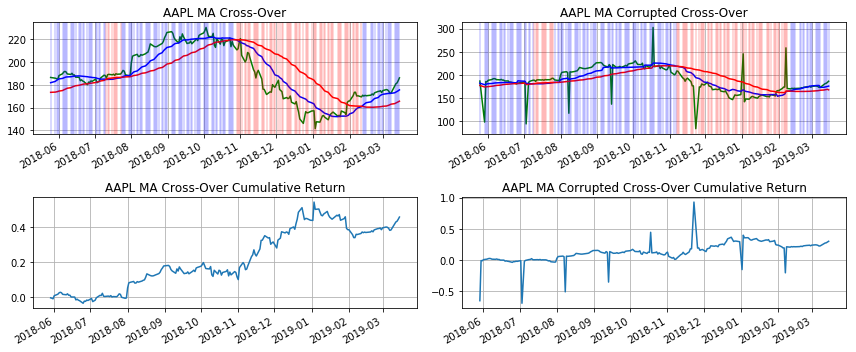

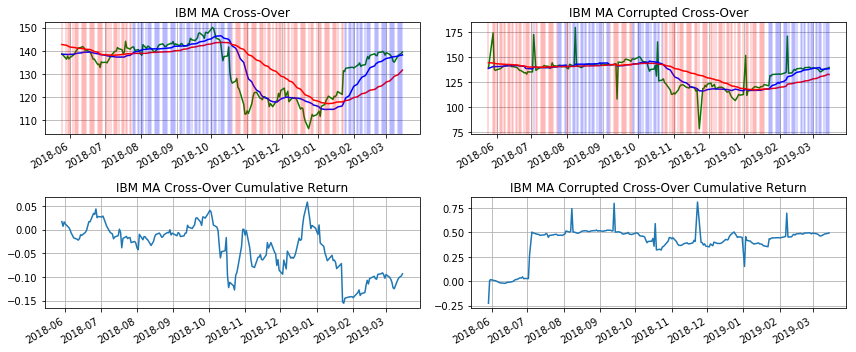

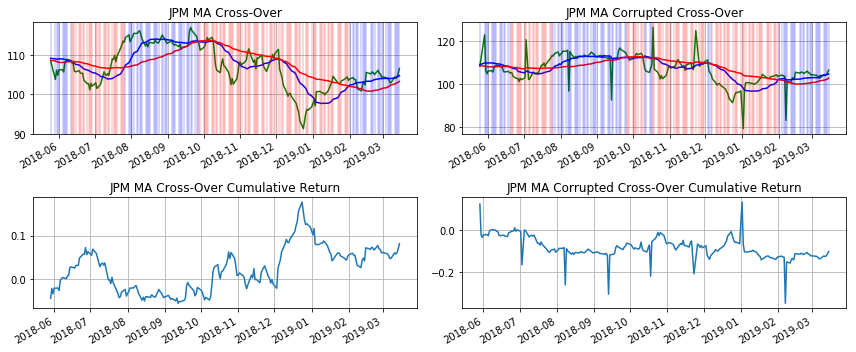

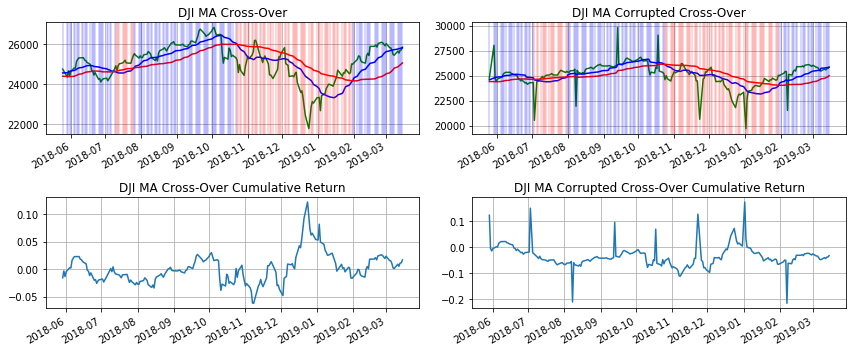

In [113]:
for ticker in tickers:
    
    # Get the time series
    ts = AdjCloses[ticker].dropna()

    # Plot Figure
    fig, ax = plt.subplots(2,2)

    # Compute moving average cross over ------------------------------------------
    ma20 = ts.rolling(20).mean()
    ma50 = ts.rolling(50).mean()
    ma_x = (ma20-ma50).dropna()
    ma_decisions = np.sign(ma_x)

    # Plot time series 
    start_idx = ma_decisions.index[0] 
    ts[start_idx:].plot(style='g-', ax=ax[0][0]) # plot raw time series in green
    ma20[start_idx:].plot(style='b-', ax=ax[0][0]) # plot MA20 in blue
    ma50[start_idx:].plot(style='r-', ax=ax[0][0]) # plot MA50 in red

    # Plot decision regions
    for idx in ma_decisions.index:
        if ma_decisions[idx]==1:
            ax[0][0].axvline(x=idx, alpha=0.2, color='b') # long regions in blue
        if ma_decisions[idx]==-1:
            ax[0][0].axvline(x=idx, alpha=0.2, color='r') # short regions in red

    # Plot the cumulative returns
    rs = np.log(ts[ma_decisions.index[0]:]).diff(1)
    rs *= ma_decisions
    cum_rs = rs.cumsum()
    cum_rs.plot(ax=ax[1][0])
    
    old_decisions = ma_decisions.copy()

    # Outliers --------------------------------------------------------------------
    # Get the time series
    ts = CAdjCloses[ticker].dropna()

    # Compute MA cross over
    ma20 = ts.rolling(20).mean()
    ma50 = ts.rolling(50).mean()
    ma_x = (ma20-ma50).dropna()
    ma_decisions = np.sign(ma_x)

    # Plot time series 
    start_idx = ma_decisions.index[0] 
    ts[start_idx:].plot(style='g-', ax=ax[0][1]) # plot raw time series in green
    ma20[start_idx:].plot(style='b-', ax=ax[0][1]) # plot MA20 in blue
    ma50[start_idx:].plot(style='r-', ax=ax[0][1]) # plot MA50 in red

    # Plot decision regions
    for idx in ma_decisions.index:
        if ma_decisions[idx]==1:
            ax[0][1].axvline(x=idx, alpha=0.2, color='b') # long regions in blue
        if ma_decisions[idx]==-1:
            ax[0][1].axvline(x=idx, alpha=0.2, color='r') # short regions in red

    # Plot the cumulative returns
    rs = np.log(ts[ma_decisions.index[0]:]).diff(1)
    rs *= ma_decisions
    cum_rs = rs.cumsum()
    cum_rs.plot(ax=ax[1][1])

    new_decisions = ma_decisions.copy()

    # Plot setting
    ax[0][0].grid()
    ax[0][0].set_xlabel('')
    ax[0][0].set_title(ticker+' MA Cross-Over')

    ax[1][0].grid()
    ax[1][0].set_xlabel('')
    ax[1][0].set_title(ticker+' MA Cross-Over Cumulative Return')

    ax[0][1].grid()
    ax[0][1].set_xlabel('')
    ax[0][1].set_title(ticker+' MA Corrupted Cross-Over')

    ax[1][1].grid()
    ax[1][1].set_xlabel('')
    ax[1][1].set_title(ticker+' MA Corrupted Cross-Over Cumulative Return')

    fig.set_size_inches(12,5)
    fig.tight_layout()
    
    print(ticker, ' \t region overlap (%): ', len(new_decisions[new_decisions==old_decisions])/len(old_decisions)*100)

### 4.4.2. Robust Moving Median Cross Over

This section explores the moving median cross-over strategy instead using the same windows as the previous section and the same logic. The performance of this strategy is plotted in the figues below for each of the assets, where the orginal and the disturbed times serieses are the same as the ones in the moving average strategy to make the comparison sensible. As expected, the introduction of the outliers in this strategy makes very little impact due to the robustness of the median estimate. The overlap of long-short decision points for the corrupted and non-corrupted scenarios average about 98%, which is higher than the 92% overlap in the moving average case.   

AAPL  	 region overlap (%):  99.00990099009901
IBM  	 region overlap (%):  97.02970297029702
JPM  	 region overlap (%):  97.52475247524752
DJI  	 region overlap (%):  99.00990099009901


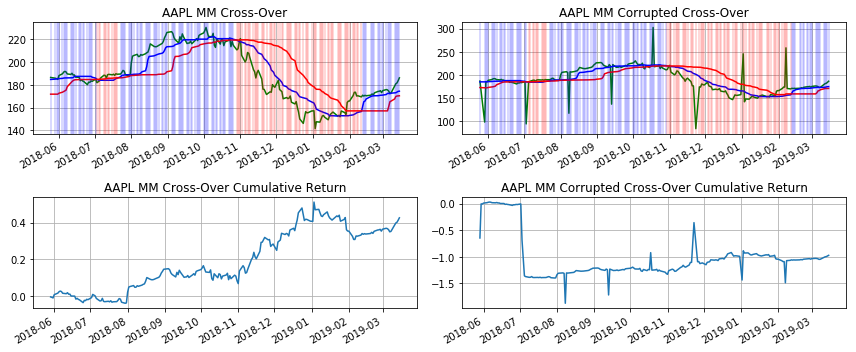

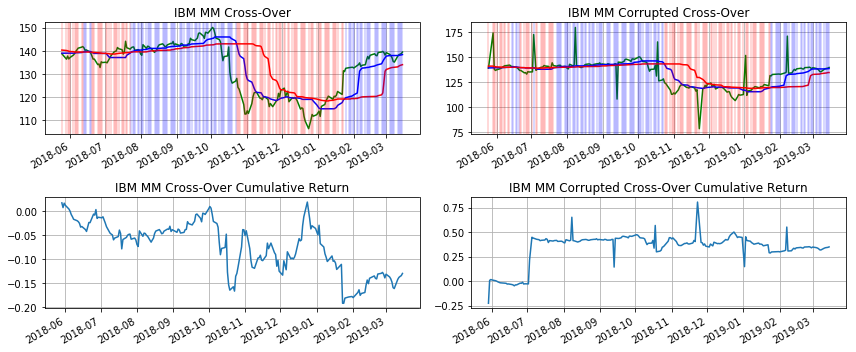

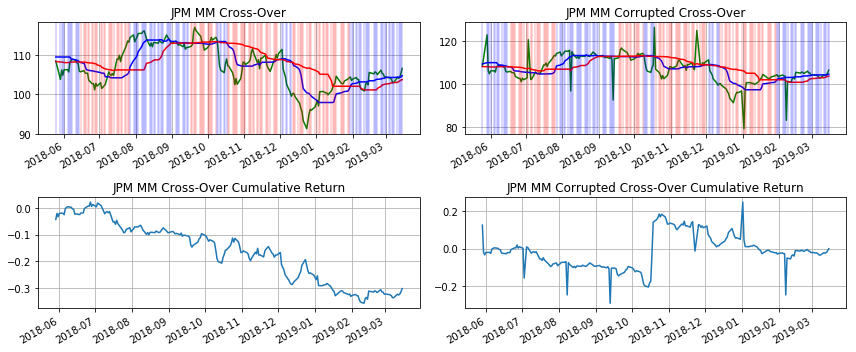

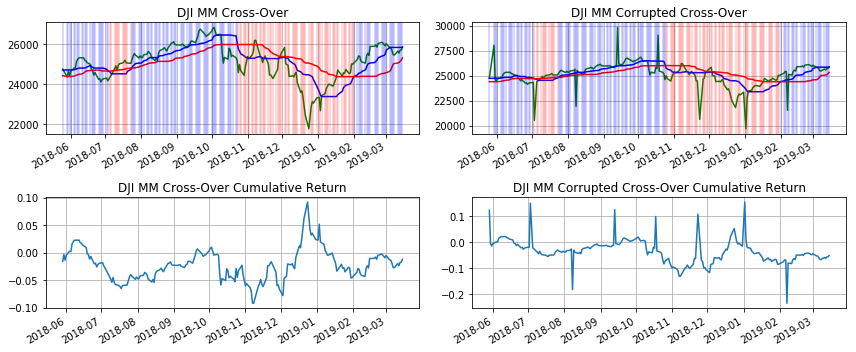

In [114]:
for ticker in tickers:

    # Get the time series
    ts = AdjCloses[ticker].dropna()

    # Plot Figure
    fig, ax = plt.subplots(2,2)

    # Compute moving median cross over ------------------------------------------
    mm20 = ts.rolling(20).median()
    mm50 = ts.rolling(50).median()
    mm_x = (mm20-mm50).dropna()
    mm_decisions = np.sign(mm_x)

    # Plot time series 
    start_idx = mm_decisions.index[0] 
    ts[start_idx:].plot(style='g-', ax=ax[0][0]) # plot raw time series in green
    mm20[start_idx:].plot(style='b-', ax=ax[0][0]) # plot MM20 in blue
    mm50[start_idx:].plot(style='r-', ax=ax[0][0]) # plot MM50 in red

    # Plot decision regions
    for idx in mm_decisions.index:
        if mm_decisions[idx]==1:
            ax[0][0].axvline(x=idx, alpha=0.2, color='b') # long regions in blue
        if mm_decisions[idx]==-1:
            ax[0][0].axvline(x=idx, alpha=0.2, color='r') # short regions in red

    # Plot the cumulative returns
    rs = np.log(ts[mm_decisions.index[0]:]).diff(1)
    rs *= mm_decisions
    cum_rs = rs.cumsum()
    cum_rs.plot(ax=ax[1][0])

    old_decisions = mm_decisions.copy()

    # Outliers --------------------------------------------------------------------
    # Get the time series
    ts = CAdjCloses[ticker].dropna()

    # Compute MA cross over
    mm20 = ts.rolling(20).median()
    mm50 = ts.rolling(50).median()
    mm_x = (mm20-mm50).dropna()
    mm_decisions = np.sign(mm_x)

    # Plot time series 
    start_idx = mm_decisions.index[0] 
    ts[start_idx:].plot(style='g-', ax=ax[0][1]) # plot raw time series in green
    mm20[start_idx:].plot(style='b-', ax=ax[0][1]) # plot MM20 in blue
    mm50[start_idx:].plot(style='r-', ax=ax[0][1]) # plot MM50 in red

    # Plot decision regions
    for idx in mm_decisions.index:
        if mm_decisions[idx]==1:
            ax[0][1].axvline(x=idx, alpha=0.2, color='b') # long regions in blue
        if mm_decisions[idx]==-1:
            ax[0][1].axvline(x=idx, alpha=0.2, color='r') # short regions in red

    # Plot the cumulative returns
    rs = np.log(ts[mm_decisions.index[0]:]).diff(1)
    rs *= mm_decisions
    cum_rs = rs.cumsum()
    cum_rs.plot(ax=ax[1][1])

    new_decisions = mm_decisions.copy()

    # Plot setting
    ax[0][0].grid()
    ax[0][0].set_xlabel('')
    ax[0][0].set_title(ticker+' MM Cross-Over')

    ax[1][0].grid()
    ax[1][0].set_xlabel('')
    ax[1][0].set_title(ticker+' MM Cross-Over Cumulative Return')

    ax[0][1].grid()
    ax[0][1].set_xlabel('')
    ax[0][1].set_title(ticker+' MM Corrupted Cross-Over')

    ax[1][1].grid()
    ax[1][1].set_xlabel('')
    ax[1][1].set_title(ticker+' MM Corrupted Cross-Over Cumulative Return')

    fig.set_size_inches(12,5)
    fig.tight_layout()

    print(ticker, ' \t region overlap (%): ', len(new_decisions[new_decisions==old_decisions])/len(old_decisions)*100)

# 5. Graphs in Finance

## 5.1. S&P Stocks Selection

In [115]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [116]:
# Load data
df = pd.read_csv('DataSource/snp_allstocks_2015_2019.csv', header=0, index_col=0)
info = pd.read_csv('DataSource/snp_info.csv', index_col=0)

In [117]:
# Get all the financial companies
info_Fin = info[info['GICS Sector']=='Financials'] # Financials
info_FinNY = info_Fin[info_Fin['Headquarters Location']=='New York, New York'] # HQ New York
universe = ['BLK','AXP','JPM','SPGI','MMC','MS','MET','L','AIG','C'] # Biggest per GICS Sub Industry with complete data (JEF dropped for C)
ri = np.log(df[universe].dropna(1)).diff(1).dropna() # the the returns
(info_FinNY.sort_values('GICS Sub Industry'))

Security Symbol SEC filings GICS Sector  \
74                           BlackRock    BLK     reports  Financials   
67   The Bank of New York Mellon Corp.     BK     reports  Financials   
33                 American Express Co    AXP     reports  Financials   
117                     Citigroup Inc.      C     reports  Financials   
273               JPMorgan Chase & Co.    JPM     reports  Financials   
423                   S&P Global, Inc.   SPGI     reports  Financials   
329                       Moody's Corp    MCO     reports  Financials   
333                           MSCI Inc   MSCI     reports  Financials   
335                       Nasdaq, Inc.   NDAQ     reports  Financials   
307                   Marsh & McLennan    MMC     reports  Financials   
165                            E*Trade   ETFC     reports  Financials   
221                Goldman Sachs Group     GS     reports  Financials   
330                     Morgan Stanley     MS     reports  Financials   
318                       MetLife Inc.    MET     reports  Financials   
269          Jefferies Financial Group    JEF     reports  Financials   
298                        Loews Corp.      L     reports  Financials   
57                       Assurant Inc.    AIZ     reports  Financials   
34        American International Group    AIG     reports  Financials   
451       The Travelers Companies Inc.    TRV     reports  Financials   

                    GICS Sub Industry Headquarters Location  \
74   Asset Management & Custody Banks    New York, New York   
67   Asset Management & Custody Banks    New York, New York   
33                   Consumer Finance    New York, New York   
117                 Diversified Banks    New York, New York   
273                 Diversified Banks    New York, New York   
423        Financial Exchanges & Data    New York, New York   
329        Financial Exchanges & Data    New York, New York   
333        Financial Exchanges & Data    New York, New York   
335        Financial Exchanges & Data    New York, New York   
307                 Insurance Brokers    New York, New York   
165    Investment Banking & Brokerage    New York, New York   
221    Investment Banking & Brokerage    New York, New York   
330    Investment Banking & Brokerage    New York, New York   
318           Life & Health Insurance    New York, New York   
269             Multi-Sector Holdings    New York, New York   
298              Multi-line Insurance    New York, New York   
57               Multi-line Insurance    New York, New York   
34      Property & Casualty Insurance    New York, New York   
451     Property & Casualty Insurance    New York, New York   

    Date first added[3][4]      CIK Founded  
74              2011-04-04  1364742     NaN  
67              1995-03-31  1390777     NaN  
33              1976-06-30     4962    1850  
117             1988-05-31   831001     NaN  
273             1975-06-30    19617     NaN  
423                    NaN    64040     NaN  
329                    NaN  1059556    1909  
333             2018-04-04  1408198     NaN  
335             2008-10-22  1120193     NaN  
307             1987-08-31    62709     NaN  
165             2004-03-31  1015780     NaN  
221             2002-07-22   886982     NaN  
330                    NaN   895421    1935  
318                    NaN  1099219    1868  
269             2007-08-27    96223     NaN  
298                    NaN    60086     NaN  
57              2007-04-10  1267238     NaN  
34              1980-03-31     5272    1919  
451             2002-08-21    86312     NaN

This section will explore the use of graphical methods to infer relationships among the given assets. Specifically, this section will analyse the relationship of the 10 stocks listed in the table below. These 10 stocks are the New York based financial companies which are biggest in their respective GICS Sub Industry by market capitalization. 

This particular screening was chosen due to the intricate relationship that exists among the financial institutions, which are often affected by the same regulations and macroeconomic factors, such as change in interest rates or the yield curve inversion. In addition, by limiting the location to New York, all the geographical factors such as population and local laws are filtered out which will aid the ease of analysis. Finally, by excluding competitors from the same GICS sub-industries, the graphical method should highlight the underlying macro characteristics of the financial network instead of aspects relating to firm-wise competition. However, this is a generalization that will not hold true completely since there will be some overlap in the operations of these firms.

In [118]:
tmp_df = info.copy().set_index('Symbol')
tmp_df.loc[universe]

Security SEC filings GICS Sector  \
Symbol                                                         
BLK                        BlackRock     reports  Financials   
AXP              American Express Co     reports  Financials   
JPM             JPMorgan Chase & Co.     reports  Financials   
SPGI                S&P Global, Inc.     reports  Financials   
MMC                 Marsh & McLennan     reports  Financials   
MS                    Morgan Stanley     reports  Financials   
MET                     MetLife Inc.     reports  Financials   
L                        Loews Corp.     reports  Financials   
AIG     American International Group     reports  Financials   
C                     Citigroup Inc.     reports  Financials   

                       GICS Sub Industry Headquarters Location  \
Symbol                                                           
BLK     Asset Management & Custody Banks    New York, New York   
AXP                     Consumer Finance    New York, New York   
JPM                    Diversified Banks    New York, New York   
SPGI          Financial Exchanges & Data    New York, New York   
MMC                    Insurance Brokers    New York, New York   
MS        Investment Banking & Brokerage    New York, New York   
MET              Life & Health Insurance    New York, New York   
L                   Multi-line Insurance    New York, New York   
AIG        Property & Casualty Insurance    New York, New York   
C                      Diversified Banks    New York, New York   

       Date first added[3][4]      CIK Founded  
Symbol                                          
BLK                2011-04-04  1364742     NaN  
AXP                1976-06-30     4962    1850  
JPM                1975-06-30    19617     NaN  
SPGI                      NaN    64040     NaN  
MMC                1987-08-31    62709     NaN  
MS                        NaN   895421    1935  
MET                       NaN  1099219    1868  
L                         NaN    60086     NaN  
AIG                1980-03-31     5272    1919  
C                  1988-05-31   831001     NaN

## 5.2. Correlation Based Network 

This section will explore the construction of a network based on the correlation matrix of the returns of the 10 stocks mentioned previously. The network groups each node (representing the stocks) spatially in relation to its correlation value with every other node. In the network below specifically, the edges (connections) are drawn only for pairs of nodes with a correlation value greater than 0.5 in magnitude, and all the self-correlation of value 1 are omitted from the graph. 

The correlation matrix can be interpreted as a network since it shows how each node is connected to one another. This is because the correlation of each pair represents the strength of connection that there is between the two points. This strenght can then be in turn represented spatially by placing highly connected nodes closer together and loosely connected nodes further apart. This allows the formation and visualization of local groups that demonstrate some underlying relationship between the connections. 

In [119]:
# Calculate correlation matrix
corr = ri.corr()
corr

BLK       AXP       JPM      SPGI       MMC        MS       MET  \
BLK   1.000000  0.523309  0.719505  0.649981  0.637921  0.729031  0.643319   
AXP   0.523309  1.000000  0.583079  0.462673  0.469991  0.577062  0.495523   
JPM   0.719505  0.583079  1.000000  0.610638  0.626700  0.865723  0.751688   
SPGI  0.649981  0.462673  0.610638  1.000000  0.586513  0.617912  0.504903   
MMC   0.637921  0.469991  0.626700  0.586513  1.000000  0.596269  0.546175   
MS    0.729031  0.577062  0.865723  0.617912  0.596269  1.000000  0.746946   
MET   0.643319  0.495523  0.751688  0.504903  0.546175  0.746946  1.000000   
L     0.662095  0.500702  0.706175  0.531424  0.638541  0.688718  0.662437   
AIG   0.556012  0.435220  0.644480  0.459869  0.531102  0.617307  0.659178   
C     0.723413  0.574842  0.887535  0.592265  0.587256  0.856974  0.750710   

             L       AIG         C  
BLK   0.662095  0.556012  0.723413  
AXP   0.500702  0.435220  0.574842  
JPM   0.706175  0.644480  0.887535  
SPGI  0.531424  0.459869  0.592265  
MMC   0.638541  0.531102  0.587256  
MS    0.688718  0.617307  0.856974  
MET   0.662437  0.659178  0.750710  
L     1.000000  0.626197  0.669760  
AIG   0.626197  1.000000  0.637896  
C     0.669760  0.637896  1.000000

In [120]:
corr.mean().sort_values()

AXP     0.562240
SPGI    0.601618
AIG     0.616726
MMC     0.622047
L       0.668605
MET     0.676088
BLK     0.684459
C       0.728065
MS      0.729594
JPM     0.739552
dtype: float64

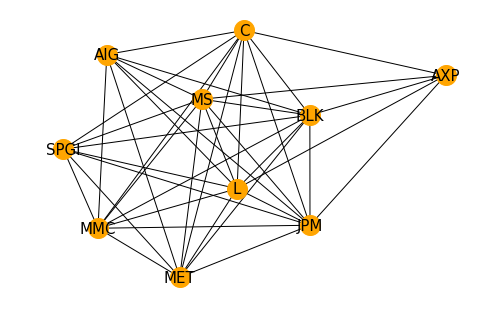

In [121]:
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ abs(links['value'] > 0.5) & (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

## 5.3. Correlation Network Analysis 

As shown in the network drawn above, it can be seen that most of the stocks are concentrated around a main group with JPM at its center, while there are two outliers AXP and SPGI which are placed slightly far away from the rest. This is reflective of their correlation value since JPM has the highest correlation with every other node on average (74%) compared to the rest of the stocks. Similarly, AXP and SPGI have the least amount of correlation (56% and 60% respectively).

This spatial relationship is also reflective of the business nature of these stocks. For instance, the main business line of the American Express Co. (AXP) is the deposit business which is centered around their debit and credit cards, and not any retail banking or investment banking activities such as the majority of the stocks in consideration. For this reason, it is placed far away from the central group, as it is relatively less correlated with the rest.

Similarly, the main business lines of S&P Global (SPGI) are data, analytics and rating provision, which are different business operations from banking and brokerage. However, since its services are used across multiple financial institutions, it's still connected with the remaining nodes.

For the opposite reason, the central position of banks with diversified operations such as JP Morgan Chase & Co. (JPM) is due to the diversified nature of its businesses. Since it operates in a variety of businesses such as asset management, brokerage, retail and investment banking and many more, they have branches that overlap in operation with most of the stocks present in the list, making them the assets with the return most correlated with the rest. 

Finally, the correlation is a measure of similarity between realization of two random variables that is unaffected by the re-ordering of the values or the indices. Although the graph will not be the same every time, the overall arrangement and local groupping will remain constant for any type of re-shuffling as long as the operation is applied equally across all realizations. This is is shown in the figure below where the network is draw for returns that are randomly re-shuffled in time. 

[REF of business analytics]

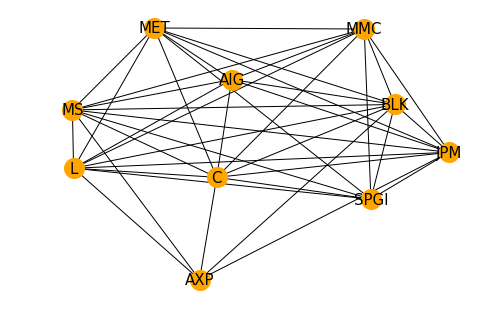

In [122]:
# Calculate correlation matrix
corr = ri.sample(frac=1, axis=0).corr()

# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (abs(links['value']) > 0.5) & (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

## 5.4. Spectral Similarity Network

This section explores the construction of a network based on the power spectrum characteristics. Specifically, the power characteristics with associated frequencies are computed for all the given stocks using the Fourier transform. Then, the correlation is computed for each pair as a measure of similarity between the power spectrums. Both the spectral correlation matrix and the associated network are plotted below, where the edges are drawn only for pairs that have correlation greater than 0.3 and self-correlations are omitted. 

The main justification for this measure of similarity is based on the fact that firms undergo different business and economic cycles that can affect the returns. Therefore, by using this metric, it is possible to construct a visual representation of which firms are affected by similar business or economic cycles. 

Text(0.5,1,'Returns Power Spectrums')

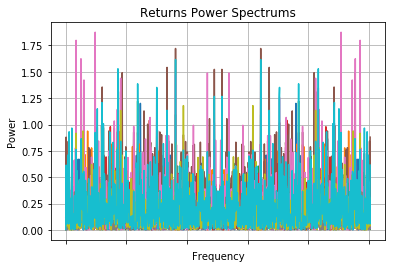

In [123]:
# Create the similarity matrix
PSs = pd.DataFrame(index=ri.index, columns=ri.columns)

# Go through tickers
for ticker1 in ri.columns:
    PSs[ticker1]=np.abs(np.fft.fft(ri[ticker1]))**2 

# Plot of Power Spectrum 
PSs.plot(legend=False, grid=True)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Returns Power Spectrums')

In [124]:
# Use correlation to measure similarity
corr = PSs.corr()
corr

BLK       AXP       JPM      SPGI       MMC        MS       MET  \
BLK   1.000000  0.147365  0.466777  0.401535  0.412731  0.511524  0.331406   
AXP   0.147365  1.000000  0.309494  0.125683  0.146337  0.263841  0.186115   
JPM   0.466777  0.309494  1.000000  0.356665  0.403926  0.717684  0.509668   
SPGI  0.401535  0.125683  0.356665  1.000000  0.349122  0.353108  0.214902   
MMC   0.412731  0.146337  0.403926  0.349122  1.000000  0.339972  0.267499   
MS    0.511524  0.263841  0.717684  0.353108  0.339972  1.000000  0.516756   
MET   0.331406  0.186115  0.509668  0.214902  0.267499  0.516756  1.000000   
L     0.420180  0.214880  0.447236  0.275007  0.420331  0.404946  0.385572   
AIG   0.258357  0.195091  0.418272  0.199512  0.291693  0.384318  0.489152   
C     0.490946  0.277420  0.814169  0.324404  0.358711  0.727035  0.551179   

             L       AIG         C  
BLK   0.420180  0.258357  0.490946  
AXP   0.214880  0.195091  0.277420  
JPM   0.447236  0.418272  0.814169  
SPGI  0.275007  0.199512  0.324404  
MMC   0.420331  0.291693  0.358711  
MS    0.404946  0.384318  0.727035  
MET   0.385572  0.489152  0.551179  
L     1.000000  0.343339  0.391734  
AIG   0.343339  1.000000  0.426483  
C     0.391734  0.426483  1.000000

The figure below shows the network constructed using the power spectrum correlation matrix. Firstly, the American Express (EXP) is placed far away from the rest, which highlights the same conclusion about the nature of its business as discussed in the previous section. 

Secondly and more interestingly, this graph shows a strong symmetry which highlights the relationship between different business cycles. For instance, the main groups that lay on the line of symmetry are JPM, MS and C, which are all banks that offer multiple services that overlap with other stocks, hence explaining their central positions as their business cycles are tied with the performance of every other stock. 

On the left side of the line of symmetry there are AIG, MET, and L, which are all insurance companies, and hence subject to similar cycles. The insurance business cycles doesn't affect as much the firms operating in asset managment, brokerage or data provision, which explains why BLK, MMC and SPGI are placed on the opposite side. 

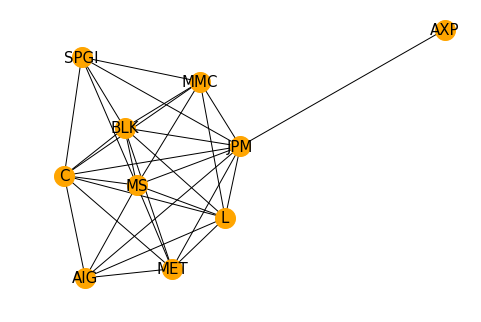

In [125]:
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[(abs(links['value']) > 0.3) & (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

Finally, unlike to the returns of correlation matrix, the re-ordering of the returns will affect the network topology. This is because the re-ordering of the returns will affect the estimation of the power associated with each frequency component, which will in turn change the correlation matrix and hence the network. Figures below show the effect of randomly shuffling the return series time-wise.

mean absolute difference:  0.04324130959170458


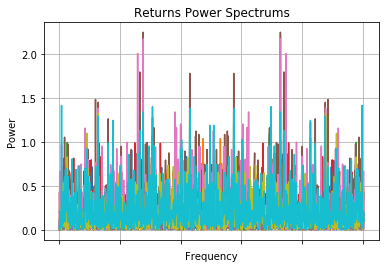

In [126]:
# Create the similarity matrix
S_PSs = pd.DataFrame(index=ri.index, columns=ri.columns)
S_ri = ri.sample(frac=1, axis=0)

# Go through tickers
for ticker1 in ri.columns:
    S_PSs[ticker1]=np.abs(np.fft.fft(S_ri[ticker1]))**2 

# Plot of Power Spectrum 
S_PSs.plot(legend=False, grid=True)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Returns Power Spectrums')

# Use correlation to measure similarity
S_corr = S_PSs.corr()

# Print mean absolute difference
print('mean absolute difference: ', (S_corr-corr).abs().mean().mean())

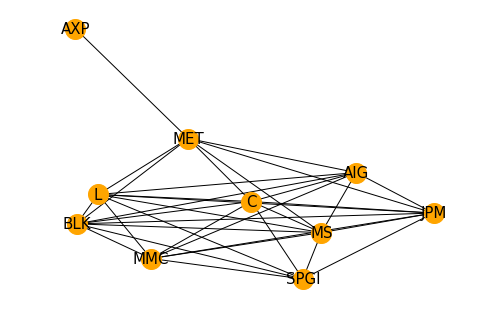

In [127]:
# Transform it in a links data frame (3 columns only):
links = S_corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[(abs(links['value']) > 0.3) & (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

## 5.5. Price vs Return Network

It is important to highlight that the above networks work only with returns and not with prices. For instance, if the network were drawn from the price correlation matrix, it would highlight the price trend relationships between each pairs of stocks. The price correlation network is drawn in the figure below. 

In [128]:
# use prices for correlation matrix
ri = df[universe].dropna(1)

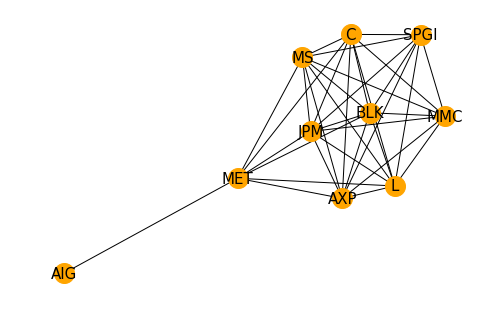

In [129]:
# Compute correlation
corr = ri.corr()

# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ abs(links['value'] > 0.5) & (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

As it is clear from the network, AIG is an outlier and it is placed far away from all other stocks. This is congruent with the fact that the AIG is the worst performing stock out of all, as it is shown in the graph below where the prices are normalized to have an initial price of one. 

Text(0.5,1,'Normalized Prices')

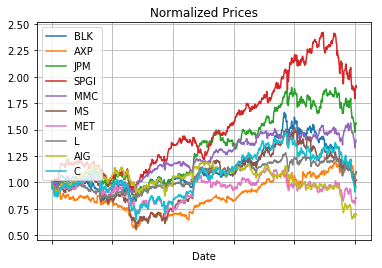

In [130]:
(ri/ri.iloc[0,:]).plot(grid=True)
plt.title('Normalized Prices')

Finally, given that the price series is not a zero-mean random variable, the power spectrum will have a strong bias component which will contain most of the power, which will make this analysis completely obsolete. This is shown not only in the power spectrum below but also in the network where every stock is well-connected with each other since the DC component is present in all stocks. 

Text(0.5,1,'Returns Power Spectrums')

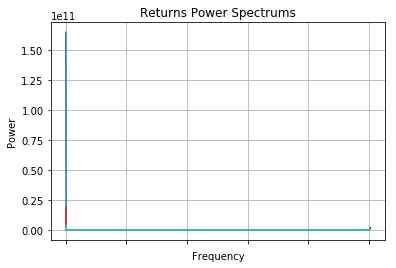

In [131]:
# Create the similarity matrix
PSs = pd.DataFrame(index=ri.index, columns=ri.columns)

# Go through tickers
for ticker1 in ri.columns:
    PSs[ticker1]=np.abs(np.fft.fft(ri[ticker1]))**2 
    
# Plot of Power Spectrum 
PSs.plot(legend=False, grid=True)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Returns Power Spectrums')

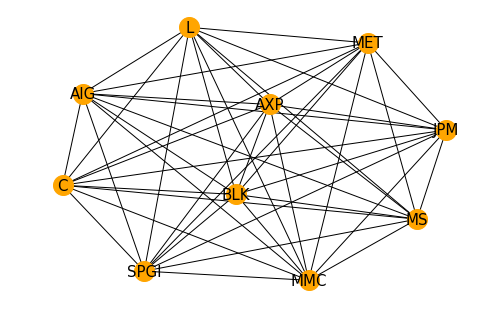

In [132]:
# Use correlation to measure similarity
corr = PSs.corr()

# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[(abs(links['value']) > 0.3) & (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)